In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from IPython.core.interactiveshell import InteractiveShell


InteractiveShell.ast_node_interactivity = 'all' 
plt.style.use('ggplot')

In [2]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [3]:
import json

model_root = 'trained_models/reinforcement_learning'
results = []
for model_name in os.listdir(model_root):
    with open(os.path.join(model_root, model_name, 'config.json')) as f:
        data = json.load(f)
    
    base_model = data['starting_actor_critic']
    if base_model is not None:
        base_model = os.path.basename(base_model)
    progress = pd.read_csv(os.path.join(model_root, model_name, 'progress.txt'), sep='\t')
    
    r = pd.read_csv(os.path.join('reports', f'{model_name}.csv'))
    results.append(
        {'model':model_name, 
         'base_model':base_model, 
         'epochs':progress.Epoch.count(),
         'train_enemies':''.join([str(e) for e in data['enemies']]), 
         'progress':progress,
         'result':r
        })

In [12]:
df = pd.DataFrame([(l['model'], l['base_model'], l['epochs'], l['train_enemies']) for l in results], 
                  columns=['model', 'base_model', 'epochs', 'train_enemies'])
df.sort_values('model', inplace=True)
df.reset_index(drop=True, inplace=True)
df

model          base_model  epochs train_enemies
0    1590573752.3423483                None     228          1367
1    1590579471.1575735                None    1048          1267
2    1590649982.3414495  1590579471.1575735    1336          1267
3    1590741419.5509562  1590579471.1575735       4          3458
4    1590741556.9109056  1590579471.1575735    2000          3458
..                  ...                 ...     ...           ...
99   1593648316.1374075  1593642320.5708907     250   range(1, 9)
100    1593654283.20633  1593648316.1374075     250   range(1, 9)
101   1593660212.921414    1593654283.20633     250   range(1, 9)
102   1593666437.139429   1593660212.921414     250   range(1, 9)
103  1593672786.3639085   1593666437.139429     250   range(1, 9)

[104 rows x 4 columns]

In [5]:
lists = [['1591261004.787129'], ['1591803558.255182'], ['1591891998.8024027']]
for i, row in df.iterrows():
    for l in lists:
        if row.base_model in l:
            l.append(row.model)

In [6]:
progress_list = [r['progress'] for r in results if r['model'] in lists[0]]
progress_df = pd.concat(progress_list).reset_index(drop=True).reset_index()
progress_df['Epoch'] = progress_df['index']
progress_df.drop(columns='index', inplace=True)
progress_df.set_index('Epoch', inplace=True)

In [7]:
t = []
for i, experiment in enumerate(lists):
    progress_list = [r['progress'] for r in results if r['model'] in experiment]
    progress_df = pd.concat(progress_list).reset_index(drop=True).reset_index()
    progress_df['Epoch'] = progress_df['index']
    progress_df.drop(columns='index', inplace=True)
    progress_df.set_index('Epoch', inplace=True)
    progress_df['Time'] = progress_df['Time'].diff(1)
    
    t.append(progress_df.Time.median())

In [8]:
np.mean(t)
np.median(t)

26.880122582117338

28.028755426406633

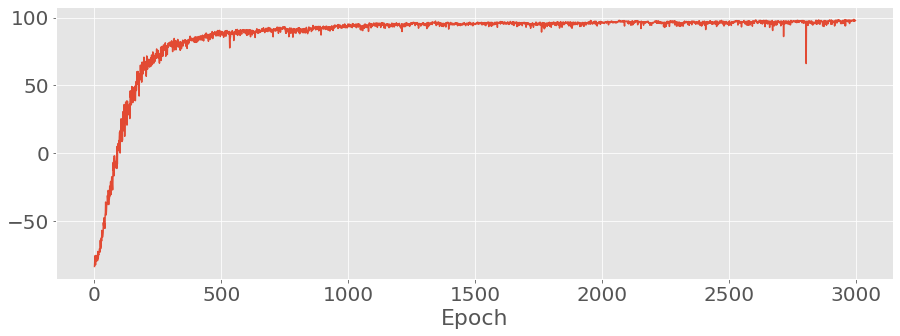

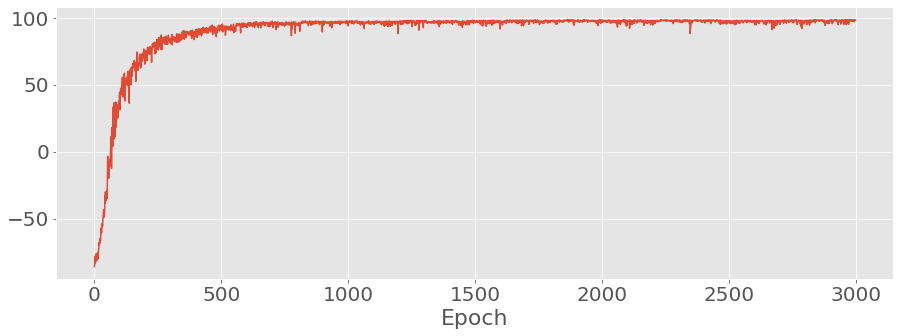

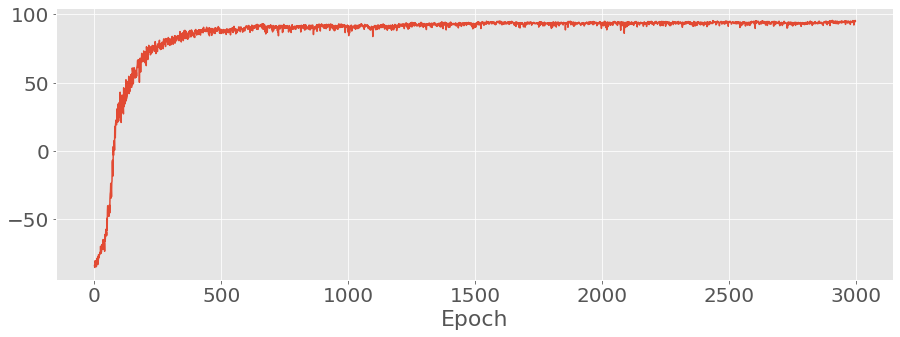

In [9]:
for i, experiment in enumerate(lists):
    progress_list = [r['progress'] for r in results if r['model'] in experiment]
    progress_df = pd.concat(progress_list).reset_index(drop=True).reset_index()
    progress_df['Epoch'] = progress_df['index']
    progress_df.drop(columns='index', inplace=True)
    progress_df.set_index('Epoch', inplace=True)
    _ = progress_df.AverageEpRet.plot()
    plt.show()
    progress_df.reset_index().to_csv(f'data_for_plots/ppo_{i}_progress.csv', index=False)

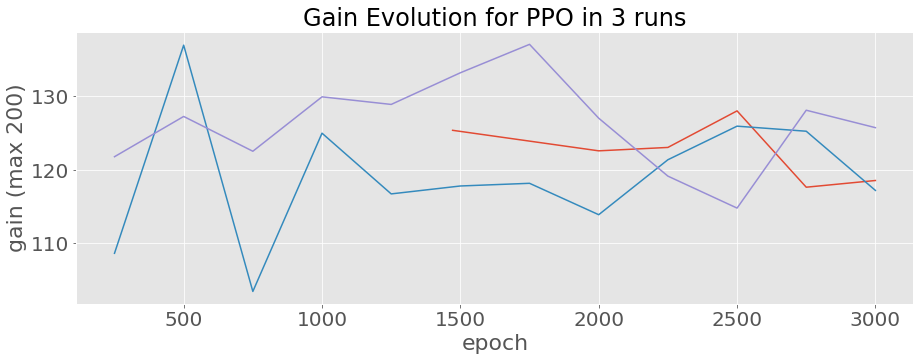

In [10]:
for i, experiment in enumerate(lists):
    progress_list = [(r['epochs'], 8 / np.sum(1 / r['result'].gain)) for r in results if r['model'] in experiment]
    progress = pd.DataFrame(progress_list, columns=['epoch', 'score'])
    progress['epoch'] = progress.epoch.cumsum()
    progress.set_index('epoch', inplace=True)
    _ = progress.score.plot()
#     plt.show()
    progress.reset_index().to_csv(f'data_for_plots/ppo_{i}_result.csv', index=False)    
_ = plt.ylabel('gain (max 200)')
_ = plt.title('Gain Evolution for PPO in 3 runs')
plt.savefig('paper/images/ppo_gain_evolution_3_runs.eps', format='eps')

In [11]:
progress_list = [(r['model'], r['epochs'], 8 / np.sum(1 / r['result'].gain)) for r in results if r['model'] in lists[2]]
progress = pd.DataFrame(progress_list, columns=['model', 'epoch', 'score'])
progress['epoch'] = progress.epoch.cumsum()
progress.set_index('epoch', inplace=True)

In [12]:
[r['result'] for r in results if r['model']=='1591935751.1014764'][0]

enemy        gain  avg_player_life  avg_enemy_life  avg_duration  \
0      1  200.010000       100.000000        0.000000    174.233333   
1      2  189.743333        89.733333        0.000000    186.433333   
2      3   86.343333         7.666667       21.333333    410.533333   
3      4   80.190000         1.846667       21.666667    736.833333   
4      5  160.530000        60.520000        0.000000    367.933333   
5      6  195.010000        95.000000        0.000000    203.533333   
6      7  185.910000        85.900000        0.000000    135.133333   
7      8  136.770000        38.760000        2.000000    443.600000   

   min_player_life  max_player_life  min_enemy_life  max_enemy_life  \
0            100.0            100.0               0             0.0   
1             78.0             96.0               0             0.0   
2              0.0             46.0               0            70.0   
3              0.0             32.2               0            60.0   
4             28.0             81.4               0             0.0   
5             85.6             98.8               0             0.0   
6             72.4             94.0               0             0.0   
7              0.0             68.2               0            40.0   

   min_duration  max_duration  percentage_games_lost  
0           159           329               0.000000  
1           143           260               0.000000  
2           263           530              53.333333  
3           420          1123              93.333333  
4           271           544               0.000000  
5           175           275               0.000000  
6           123           165               0.000000  
7           314           717              10.000000

In [13]:
last = ['1591972086.6519217', '1591880695.9546342', '1591641901.9027252']
found = [r['result'] for r in results if r['model'] in last]

r3 = [8 / np.sum(1/f.gain) for f in found]

In [14]:
last = ['1591606067.8750339', '1591851592.3176994', '1591942954.9945362']
found = [r['result'] for r in results if r['model'] in last]

r2 = [8 / np.sum(1/f.gain) for f in found]

In [15]:
r2

[122.58071320805254, 113.89813214476209, 127.01880705967213]

In [16]:
r3

[118.54738231394401, 117.20056768377583, 125.73243415137807]

In [17]:
r = pd.DataFrame(zip(r2, r3), columns=['2000 epochs', '3000 epochs'])

In [18]:
r

2000 epochs  3000 epochs
0   122.580713   118.547382
1   113.898132   117.200568
2   127.018807   125.732434

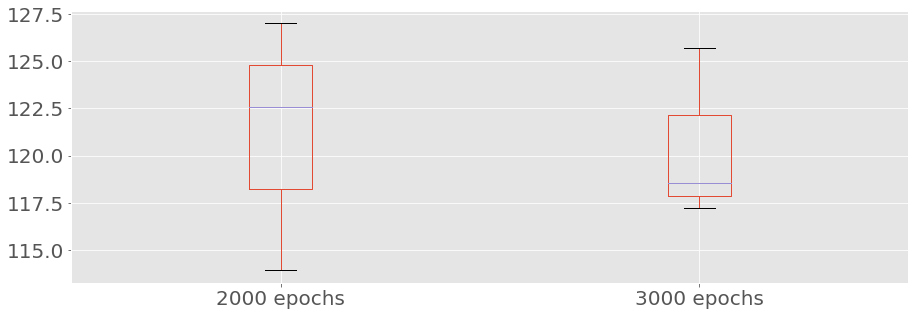

In [19]:
_ = r.boxplot()
plt.savefig('paper/images/final_epochs_comparison.eps', format='eps')

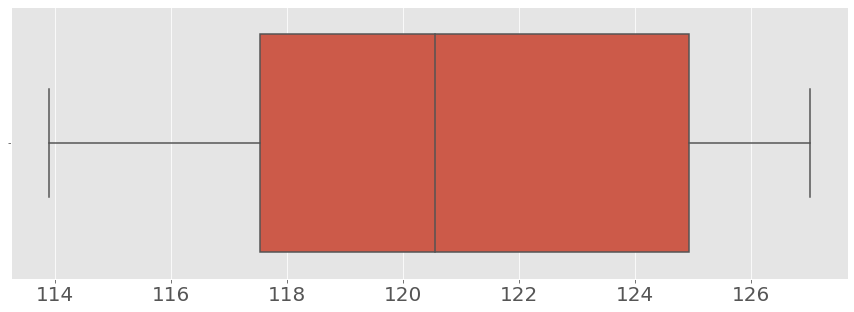

In [20]:
_ = sns.boxplot(r)

In [21]:
np.mean(r3)
np.median(r3)

np.mean(r2)
np.median(r2)

120.49346138303264

118.54738231394401

121.1658841374956

122.58071320805254

In [22]:
last2 = ['1591606067.8750339', '1591851592.3176994', '1591942954.9945362']
last3 = ['1591972086.6519217', '1591880695.9546342', '1591641901.9027252']

found = [r['result'].set_index('enemy').avg_duration for r in results if r['model'] in last2]

# r2 = [8 / np.sum(1/f.gain) for f in found]

In [23]:
model_to_gain = dict()
for r in results:
    model_to_gain[r['model']] = 8 / np.sum(1 / r['result'].gain)

In [24]:
df['gain'] = df.model.apply(lambda m: model_to_gain[m])

In [25]:
[r['result'] for r in results if r['model']=='1591972086.6519217'][0]

enemy        gain  avg_player_life  avg_enemy_life  avg_duration  \
0      1  198.410000        98.400000        0.000000    177.700000   
1      2  190.810000        90.800000        0.000000    179.033333   
2      3   70.743333         0.066667       29.333333    367.866667   
3      4   61.676667         0.000000       38.333333    569.700000   
4      5  173.830000        73.820000        0.000000    320.233333   
5      6  194.010000        94.000000        0.000000    174.133333   
6      7  192.970000        92.960000        0.000000    124.533333   
7      8  144.763333        45.086667        0.333333    427.266667   

   min_player_life  max_player_life  min_enemy_life  max_enemy_life  \
0             62.0            100.0             0.0             0.0   
1             86.0             96.0             0.0             0.0   
2              0.0              2.0             0.0            70.0   
3              0.0              0.0            10.0            60.0   
4             57.4             88.0             0.0             0.0   
5             68.8             98.2             0.0             0.0   
6             82.0             94.6             0.0             0.0   
7              0.0             73.0             0.0            10.0   

   min_duration  max_duration  percentage_games_lost  
0           158           342               0.000000  
1           142           240               0.000000  
2           225           435              96.666667  
3           393           769             100.000000  
4           259           422               0.000000  
5           153           222               0.000000  
6           123           139               0.000000  
7           269           693               3.333333

In [26]:
df

model                      base_model  epochs train_enemies  \
0   1590573752.3423483                            None     228          1367   
1   1590579471.1575735                            None    1048          1267   
2   1590649982.3414495              1590579471.1575735    1336          1267   
3   1590741419.5509562              1590579471.1575735       4          3458   
4   1590741556.9109056              1590579471.1575735    2000          3458   
5   1590827635.8673058              1590579471.1575735    2000          3467   
6   1590918282.3727078              1590579471.1575735    1665          1367   
7   1591007624.3262362              1590579471.1575735    1594          2367   
8   1591084878.9942527              1590579471.1575735    2000          2467   
9    1591130472.260961                            None    2000          2367   
10   1591261004.787129                            None    1472          1267   
11  1591296681.0770957  47.98_1591201550.222573.pickle    2000          1267   
12  1591348528.7868078  52.13_1591215640.939492.pickle    2000          1267   
13  1591429808.8947563  56.86_1591208496.467009.pickle    2000          1267   
14  1591521804.2132065  61.38_1591194194.380356.pickle    2000          1267   
15  1591606067.8750339               1591261004.787129     528          1267   
16  1591621172.6596105              1591606067.8750339     250          1267   
17  1591629797.3824728              1591621172.6596105     250          1267   
18   1591635832.204705              1591629797.3824728     250          1267   
19  1591641901.9027252               1591635832.204705     250          1267   
20   1591803558.255182                            None     250          1267   
21  1591810052.4616268               1591803558.255182     250          1267   
22  1591817160.3153307              1591810052.4616268     250          1267   
23  1591824135.7858899              1591817160.3153307     250          1267   
24  1591831061.5867038              1591824135.7858899     250          1267   
25  1591837852.4801831              1591831061.5867038     250          1267   
26   1591844700.491681              1591837852.4801831     250          1267   
27  1591851592.3176994               1591844700.491681     250          1267   
28   1591858653.952985              1591851592.3176994     250          1267   
29   1591865869.114568               1591858653.952985     250          1267   
30  1591873289.2477565               1591865869.114568     250          1267   
31  1591880695.9546342              1591873289.2477565     250          1267   
32  1591891998.8024027                            None     250          1267   
33   1591900522.664977              1591891998.8024027     250          1267   
34  1591907344.3176105               1591900522.664977     250          1267   
35   1591914476.929822              1591907344.3176105     250          1267   
36  1591921607.5572317               1591914476.929822     250          1267   
37  1591928627.3291872              1591921607.5572317     250          1267   
38  1591935751.1014764              1591928627.3291872     250          1267   
39  1591942954.9945362              1591935751.1014764     250          1267   
40  1591950327.7396142              1591942954.9945362     250          1267   
41  1591957507.0270262              1591950327.7396142     250          1267   
42   1591964820.216715              1591957507.0270262     250          1267   
43  1591972086.6519217               1591964820.216715     250          1267   

          gain  
0    26.687000  
1   100.099053  
2   122.133110  
3    95.360921  
4    44.165203  
5    75.309663  
6   110.197467  
7   136.106111  
8    85.221185  
9    99.979586  
10  125.371181  
11   43.005925  
12   45.693536  
13   59.552746  
14   89.266536  
15  122.580713  
16  123.043033  
17  128.013297  
18  117.636699  
19  118.547382  
20  108.650959  
21  136.946706  
22  103.464434  
23  124.

In [27]:
4/np.sum(1/results[0]['result'].gain[[0, 1, 5, 6]])

22.0625923959487

In [28]:
last3_names = ['1591641901.9027252', '1591880695.9546342', '1591972086.6519217']
for model_name in last3_names:
    train_hmean = [4/np.sum(1/r['result'].gain[[0, 1, 5, 6]]) for r in results if r['model']==model_name][0]
    print(model_name, train_hmean)

1591641901.9027252 197.91683911502295
1591880695.9546342 195.37391537318447
1591972086.6519217 194.01078832975938


In [29]:
for model_name in last3_names:
    train_hmean = [r['result'].gain for r in results if r['model']==model_name][0]
    print(model_name, train_hmean)

1591641901.9027252 0    197.276667
1    198.343333
2     56.810000
3     62.343333
4    171.330000
5    196.330000
6    199.750000
7    128.310000
Name: gain, dtype: float64
1591880695.9546342 0    199.810000
1    199.543333
2     52.010000
3     64.103333
4    162.263333
5    197.370000
6    185.503333
7    147.150000
Name: gain, dtype: float64
1591972086.6519217 0    198.410000
1    190.810000
2     70.743333
3     61.676667
4    173.830000
5    194.010000
6    192.970000
7    144.763333
Name: gain, dtype: float64


In [30]:
for model_name in last3_names + ['1591935751.1014764']:
    train_hmean = [r['result'].percentage_games_lost for r in results if r['model']==model_name][0]
    print(model_name, 100-train_hmean, sep='\n')

1591641901.9027252
0    100.000000
1    100.000000
2      3.333333
3      0.000000
4    100.000000
5    100.000000
6    100.000000
7     80.000000
Name: percentage_games_lost, dtype: float64
1591880695.9546342
0    100.000000
1    100.000000
2      0.000000
3      6.666667
4     96.666667
5    100.000000
6     93.333333
7    100.000000
Name: percentage_games_lost, dtype: float64
1591972086.6519217
0    100.000000
1    100.000000
2      3.333333
3      0.000000
4    100.000000
5    100.000000
6    100.000000
7     96.666667
Name: percentage_games_lost, dtype: float64
1591935751.1014764
0    100.000000
1    100.000000
2     46.666667
3      6.666667
4    100.000000
5    100.000000
6    100.000000
7     90.000000
Name: percentage_games_lost, dtype: float64


In [34]:
[r['result'] for r in results if r['model']=='1591935751.1014764'][0]

enemy        gain  avg_player_life  avg_enemy_life  avg_duration  \
0      1  200.010000       100.000000        0.000000    174.233333   
1      2  189.743333        89.733333        0.000000    186.433333   
2      3   86.343333         7.666667       21.333333    410.533333   
3      4   80.190000         1.846667       21.666667    736.833333   
4      5  160.530000        60.520000        0.000000    367.933333   
5      6  195.010000        95.000000        0.000000    203.533333   
6      7  185.910000        85.900000        0.000000    135.133333   
7      8  136.770000        38.760000        2.000000    443.600000   

   min_player_life  max_player_life  min_enemy_life  max_enemy_life  \
0            100.0            100.0               0             0.0   
1             78.0             96.0               0             0.0   
2              0.0             46.0               0            70.0   
3              0.0             32.2               0            60.0   
4             28.0             81.4               0             0.0   
5             85.6             98.8               0             0.0   
6             72.4             94.0               0             0.0   
7              0.0             68.2               0            40.0   

   min_duration  max_duration  percentage_games_lost  
0           159           329               0.000000  
1           143           260               0.000000  
2           263           530              53.333333  
3           420          1123              93.333333  
4           271           544               0.000000  
5           175           275               0.000000  
6           123           165               0.000000  
7           314           717              10.000000

In [37]:
for model_name in ['1591641901.9027252', '1591935751.1014764']:
    train_hmean = [r['result'][['avg_player_life', 'avg_enemy_life', 'avg_duration']] for r in results if r['model']==model_name][0]
    print(model_name, train_hmean, sep='\n')

1591641901.9027252
   avg_player_life  avg_enemy_life  avg_duration
0        97.266667        0.000000    159.633333
1        98.333333        0.000000    176.600000
2         0.133333       43.333333    457.266667
3         0.000000       37.666667    547.500000
4        71.320000        0.000000    379.133333
5        96.320000        0.000000    165.066667
6        99.740000        0.000000    162.066667
7        34.300000        6.000000    520.933333
1591935751.1014764
   avg_player_life  avg_enemy_life  avg_duration
0       100.000000        0.000000    174.233333
1        89.733333        0.000000    186.433333
2         7.666667       21.333333    410.533333
3         1.846667       21.666667    736.833333
4        60.520000        0.000000    367.933333
5        95.000000        0.000000    203.533333
6        85.900000        0.000000    135.133333
7        38.760000        2.000000    443.600000


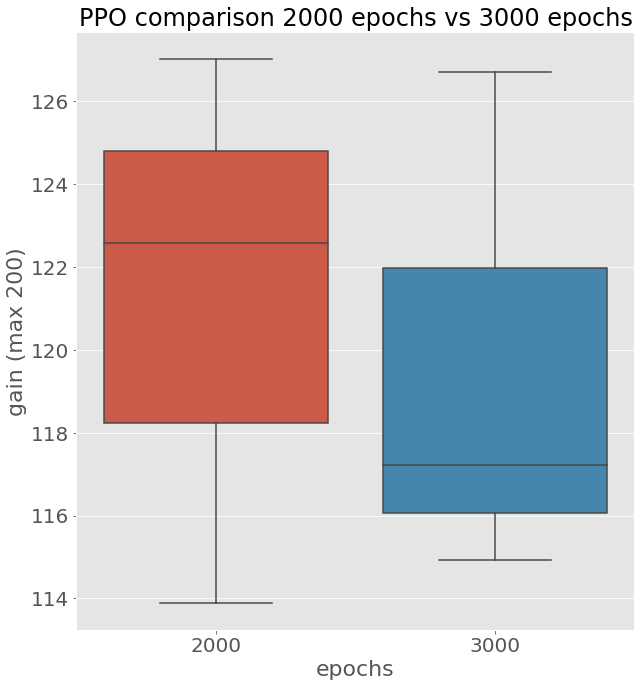

In [31]:
last2 = pd.DataFrame([122.580713, 113.898132, 127.018807], columns=['gain'])
last3 = pd.DataFrame([117.224849, 114.915070, 126.701419], columns=['gain'])
last2['epochs'] = 2000
last3['epochs'] = 3000
c = pd.merge(last2, last3, how='outer')

fig, ax = plt.subplots(figsize=(10, 11))
_ = sns.boxplot(x='epochs', y='gain', data=c, ax=ax)
_ = ax.set_ylabel('gain (max 200)')
_ = ax.set_title('PPO comparison 2000 epochs vs 3000 epochs')
fig.savefig('paper/images/ppo_2000_vs_3000_epochs.eps', format='eps')

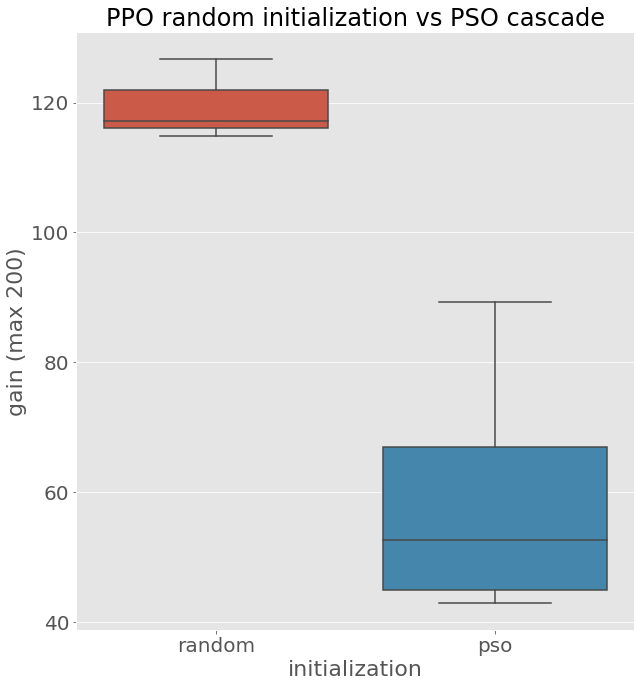

In [32]:
cascade = pd.DataFrame([43.005925, 45.693536, 59.552746, 89.266536], columns=['gain'])
ri = pd.DataFrame([117.224849, 114.915070, 126.701419, None], columns=['gain'])
ri['initialization'] = 'random'
cascade['initialization'] = 'pso'
c = pd.merge(ri, cascade, how='outer')


fig, ax = plt.subplots(figsize=(10, 11))
_ = sns.boxplot(x='initialization', y='gain', data=c, ax=ax)
_ = ax.set_title('PPO random initialization vs PSO cascade')
_ = ax.set_ylabel('gain (max 200)')
fig.savefig('paper/images/random_vs_pso_initialization.eps', format='eps')

## Training against all 8 opponents

In [39]:
def get_result_of_model(model_name):
    for r in results:
        if r['model'] == model_name:
            return r['result']
difficulties = [2, 5, 4, 3, 1]
i = 4
df.iloc[-60:].iloc[i * 12: (i + 1) * 12]

model          base_model  epochs train_enemies
56  1593337142.8598542                None     250   range(1, 9)
57  1593346142.6566477  1593337142.8598542     250   range(1, 9)
58  1593351962.3713927  1593346142.6566477     250   range(1, 9)
59  1593357856.9874532  1593351962.3713927     250   range(1, 9)
60  1593364261.5346298  1593357856.9874532     250   range(1, 9)
61  1593370284.4868336  1593364261.5346298     250   range(1, 9)
62  1593376291.5481563  1593370284.4868336     250   range(1, 9)
63  1593382218.9945776  1593376291.5481563     250   range(1, 9)
64  1593388147.1313124  1593382218.9945776     250   range(1, 9)
65   1593393879.290676  1593388147.1313124     250   range(1, 9)
66   1593399664.616021   1593393879.290676     250   range(1, 9)
67  1593405431.8708298   1593399664.616021     250   range(1, 9)

In [54]:
difficulty_to_list_of_results = dict()
for i, difficulty in enumerate(difficulties):
    ddf = df.iloc[-60:].iloc[i * 12: (i + 1) * 12].model
    _results = {(j+1) * 250: get_result_of_model(m) for j, m in enumerate(ddf)}
    difficulty_to_list_of_results[difficulty] = _results

In [66]:
def compute_final_df_for_column(column):
    final_results = []
    for difficulty in range(1, 6):
        _results = difficulty_to_list_of_results[difficulty]
        _dfs = []
        for epochs, _result in _results.items():
            _df = _result[['enemy', column]].copy()
            _df['epoch'] = epochs
            _dfs.append(_df)
        _df = pd.concat(_dfs)
        _df['difficulty'] = difficulty
        final_results.append(_df)

    return pd.concat(final_results)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


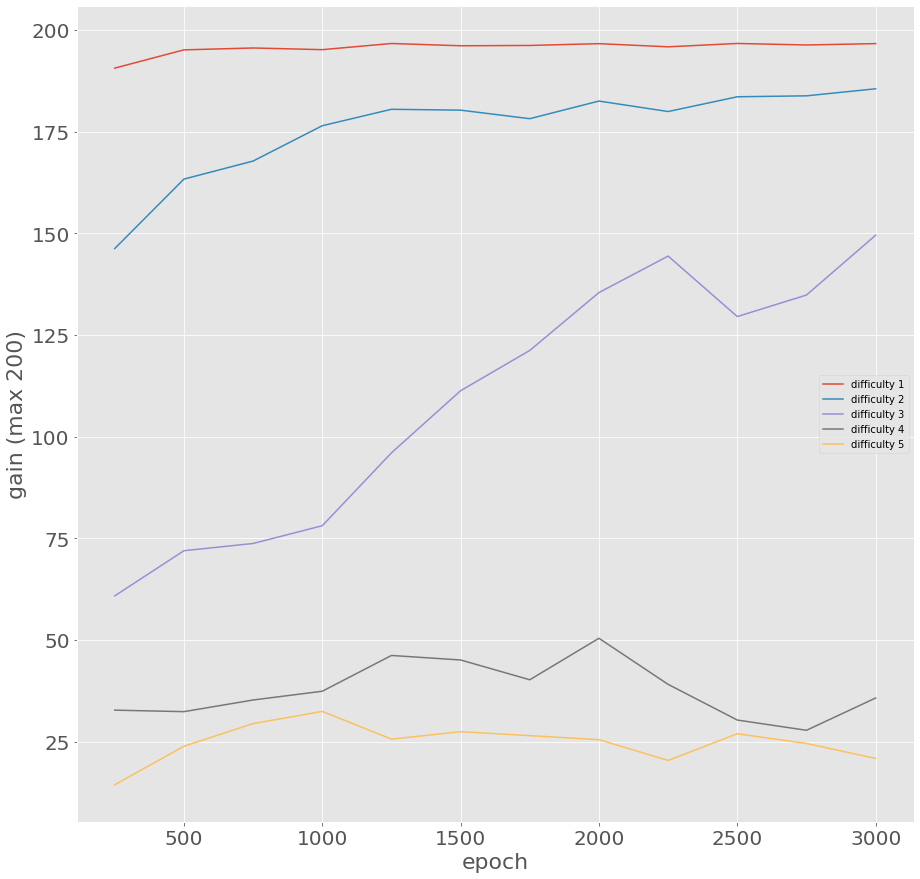

In [123]:
column = 'gain'

df_gain = compute_final_df_for_column(column)
h_df = df_gain.groupby(['difficulty', 'epoch']).apply(lambda group: group.shape[0] / np.sum(1 / group[column]))
h_df = h_df.reset_index()

fig, ax = plt.subplots(figsize=(15, 15))

for difficulty in range(1, 6):
    _ = h_df.query(f'difficulty=={difficulty}').set_index('epoch')[0].plot(ax=ax, label=f'difficulty {difficulty}')
            
_ = ax.set_ylabel('gain (max 200)')
_ = ax.legend()

fig.savefig(f'paper/images/general_harmonic_gain.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

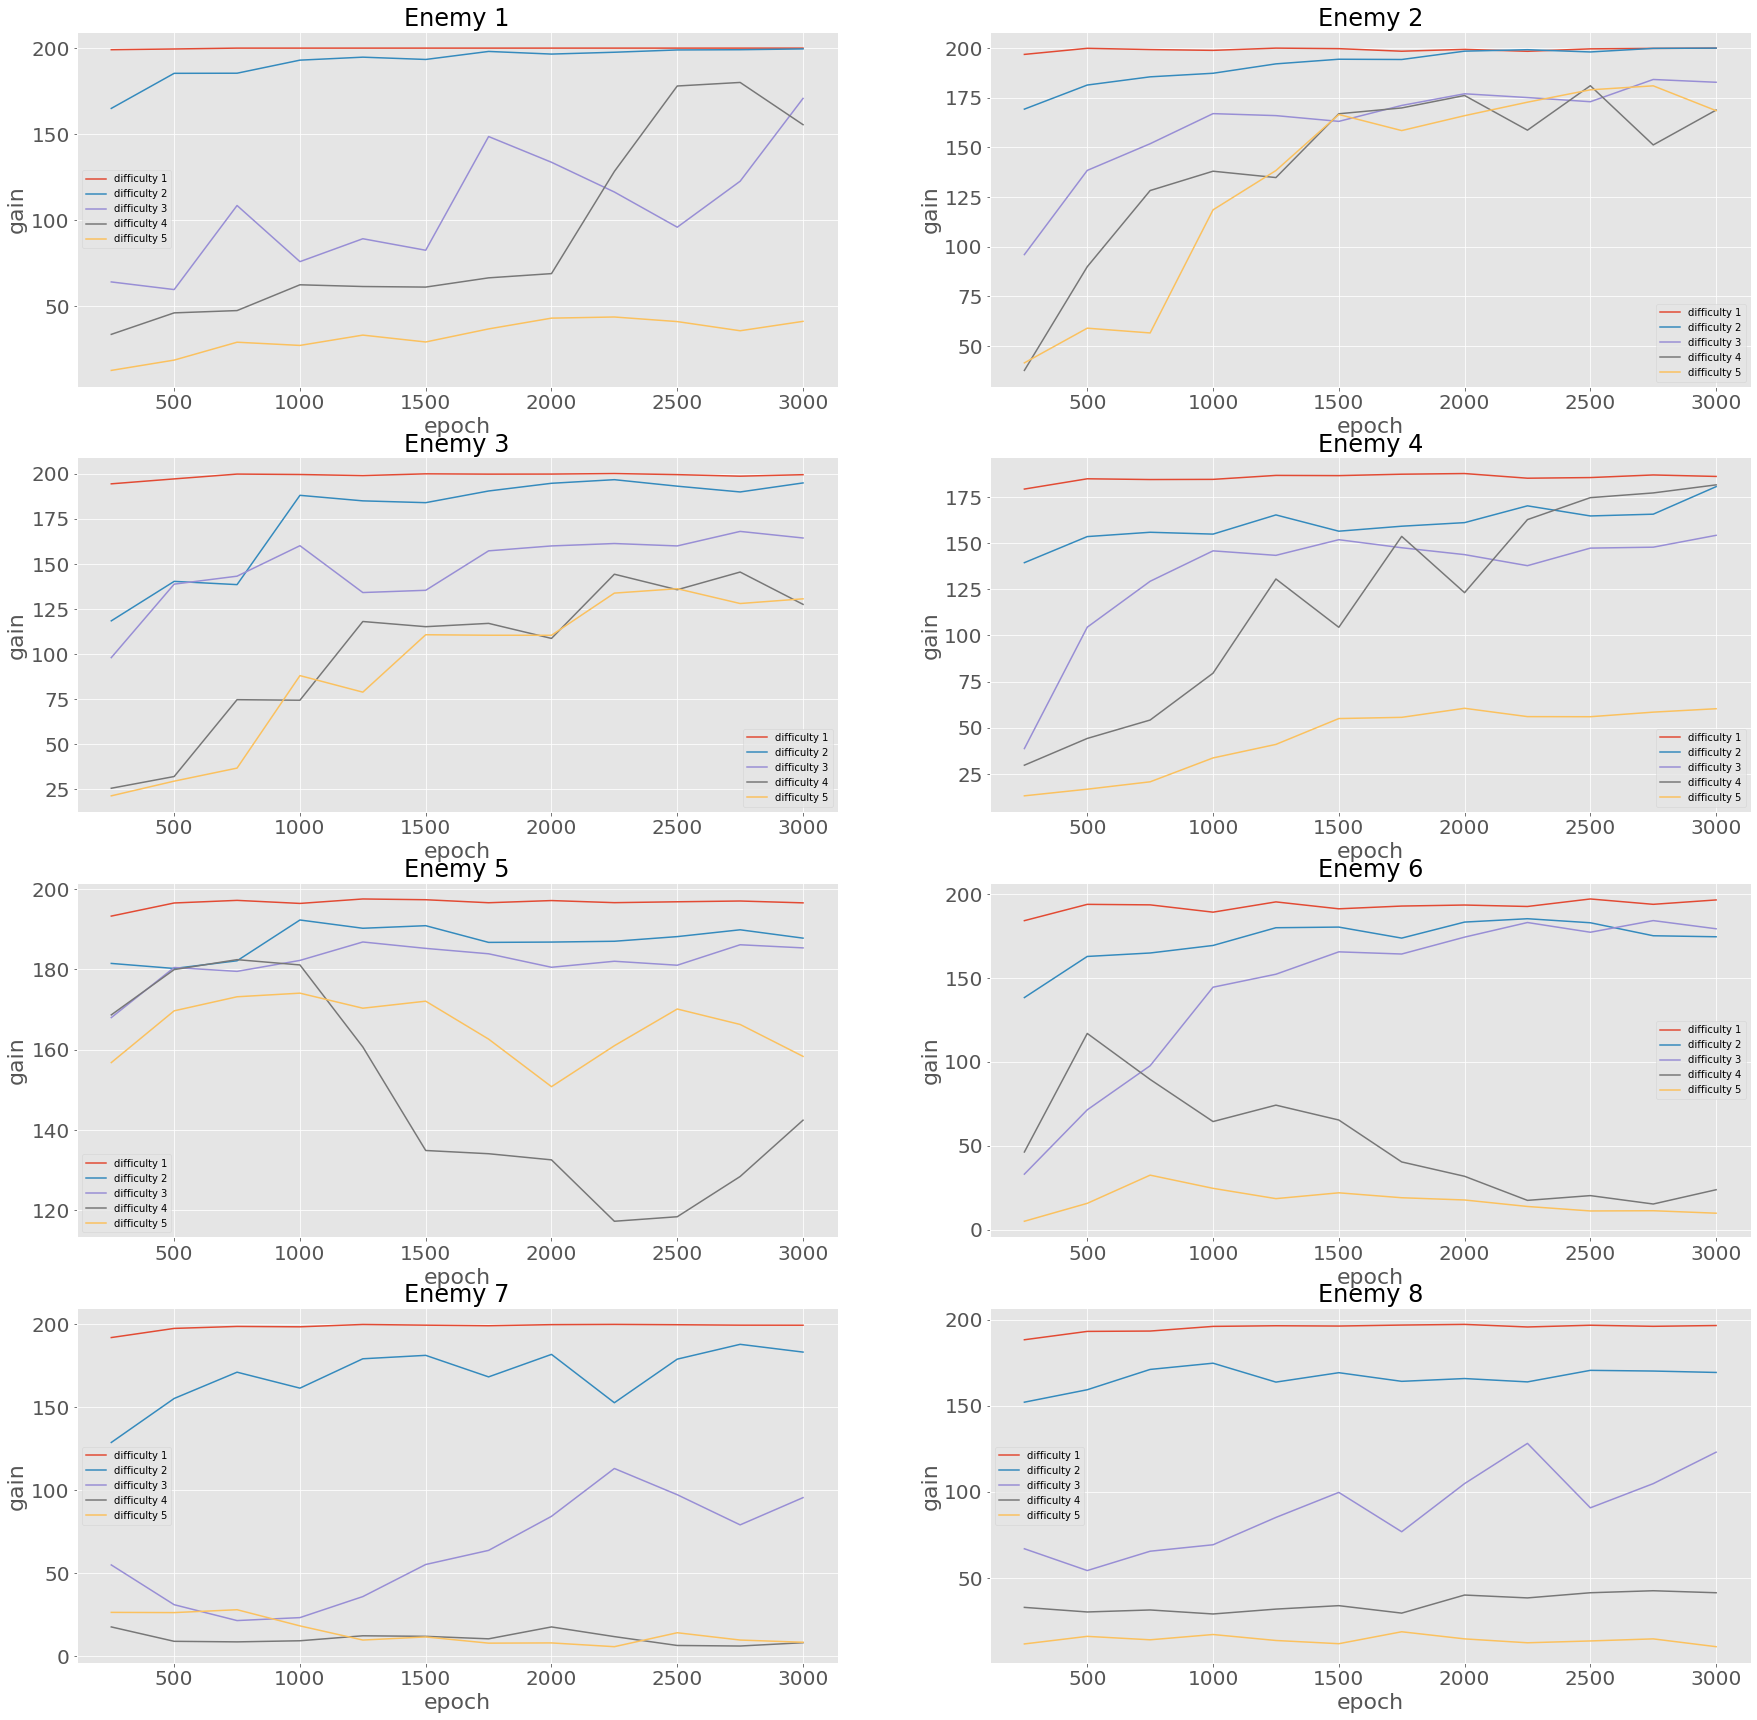

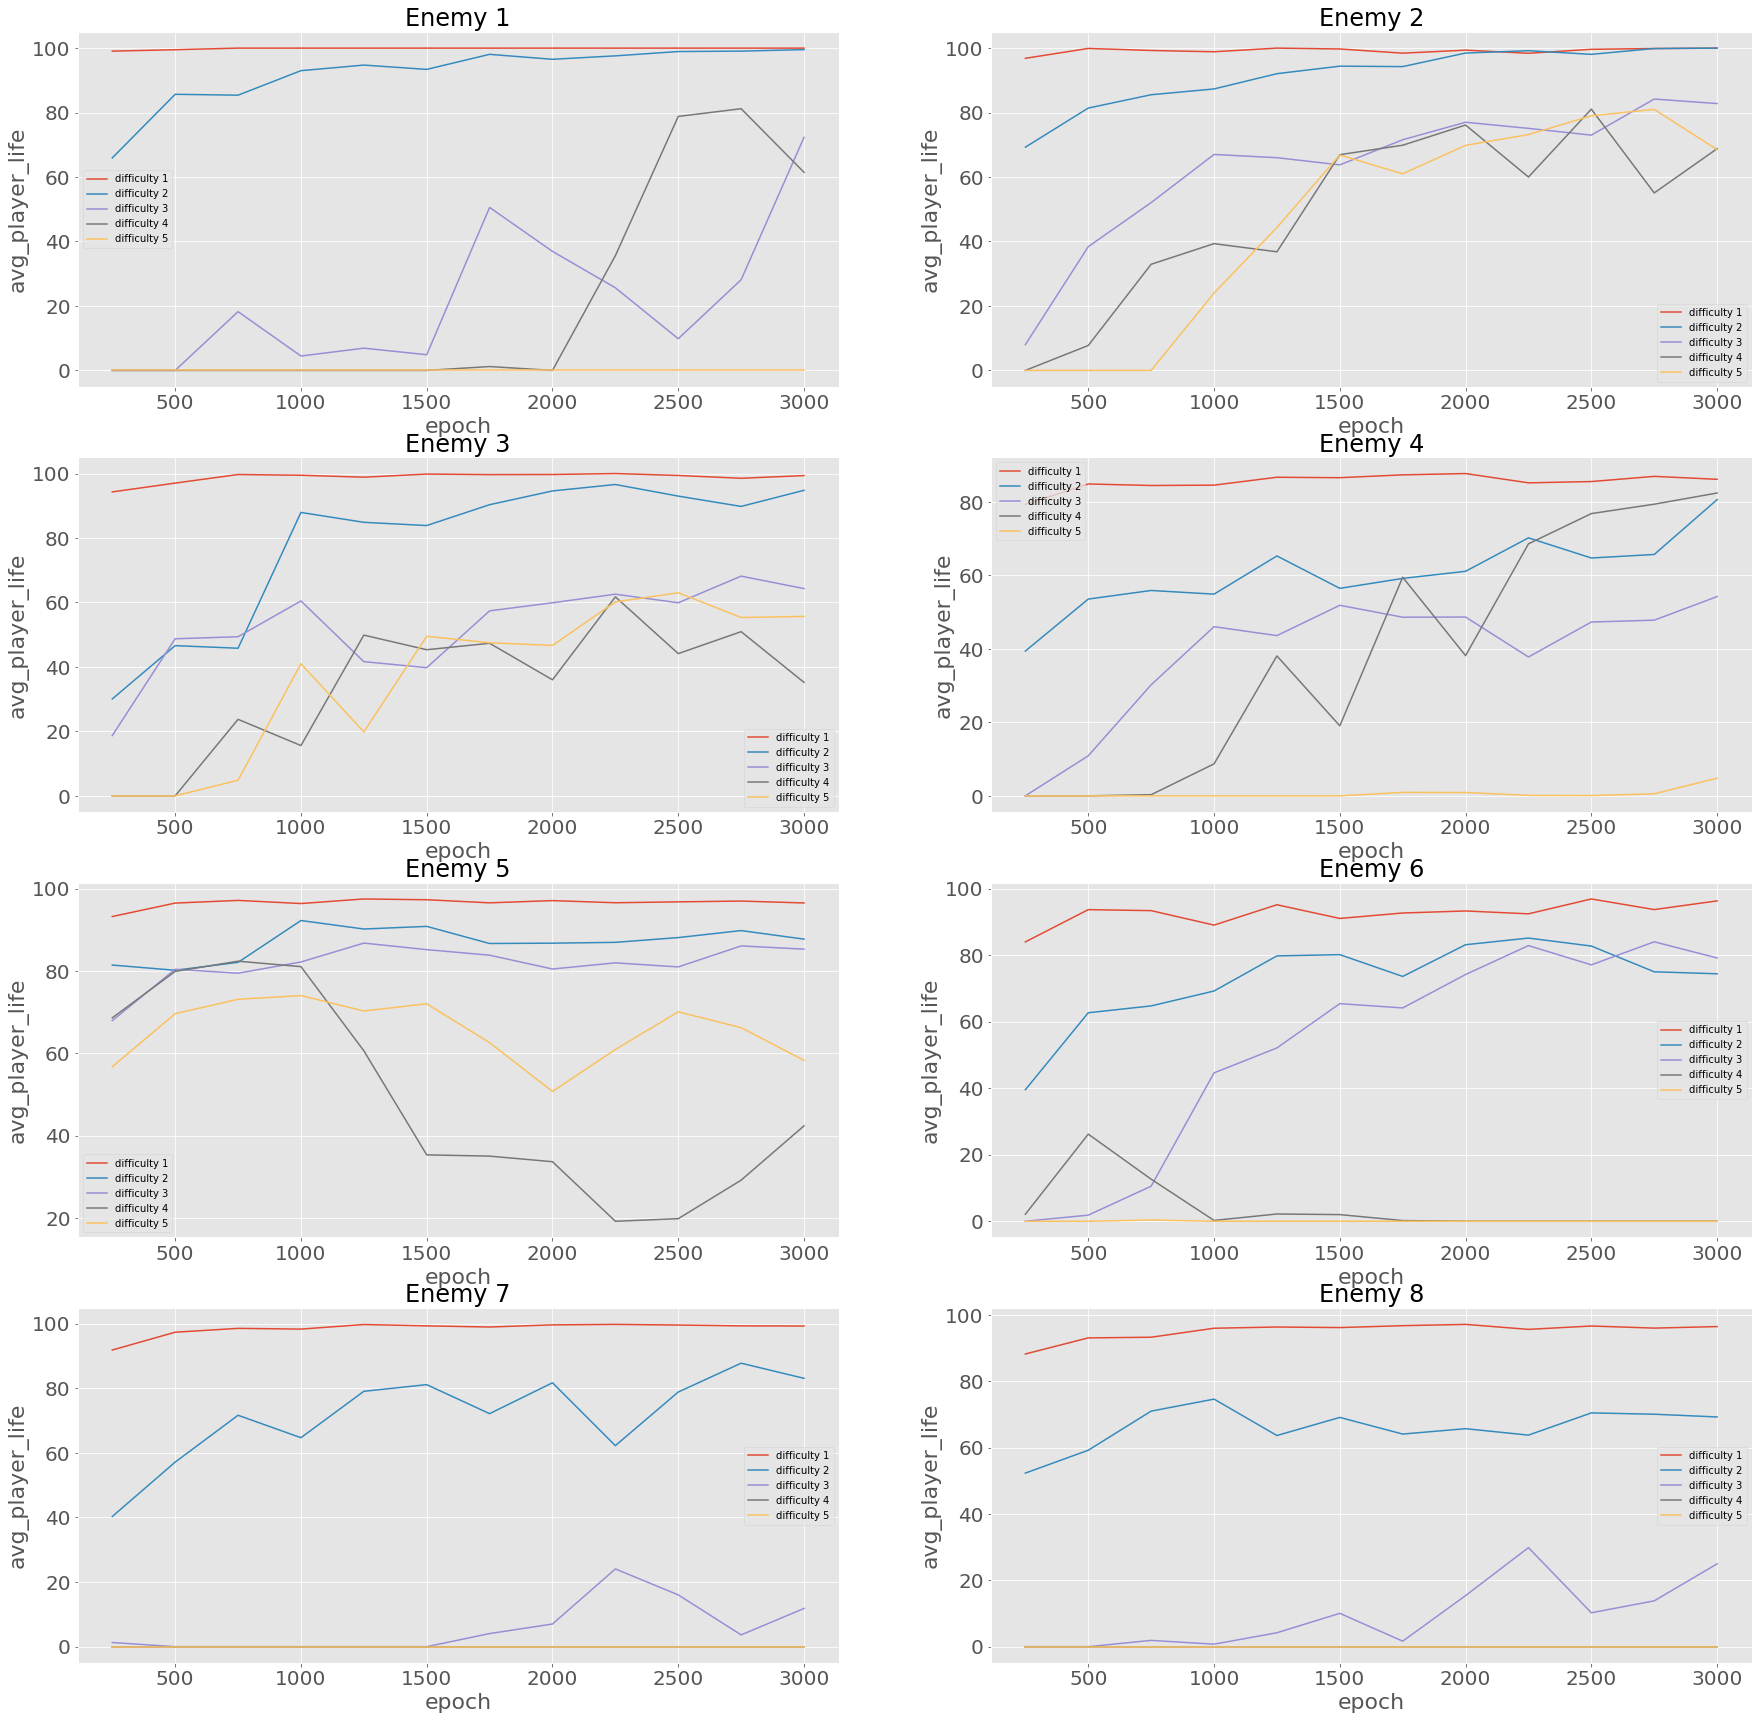

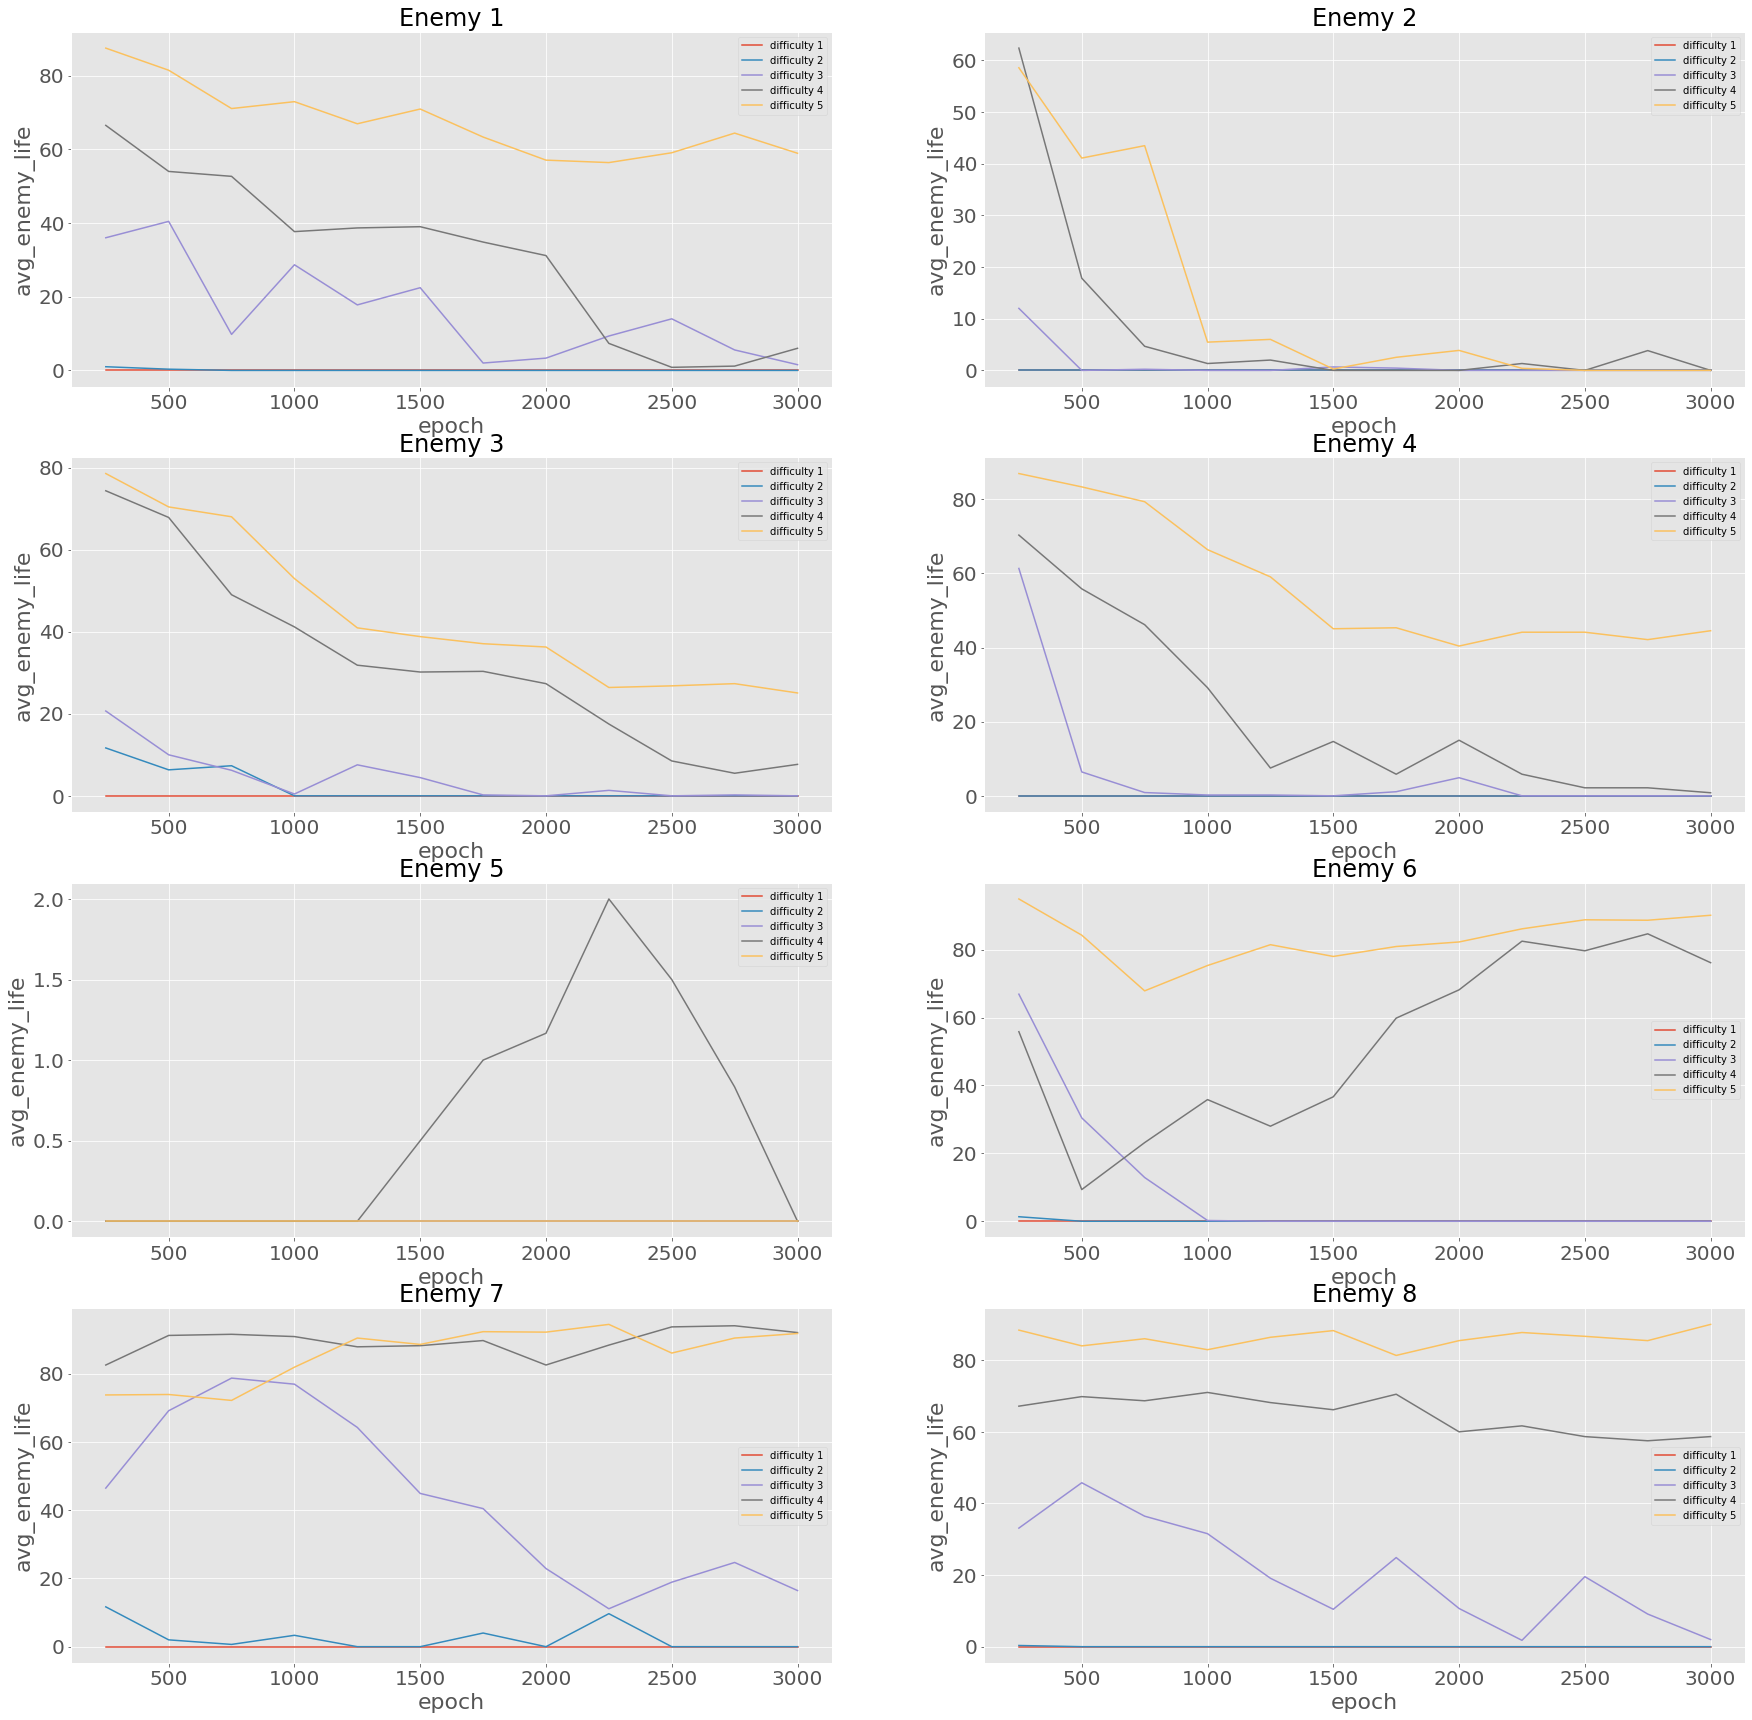

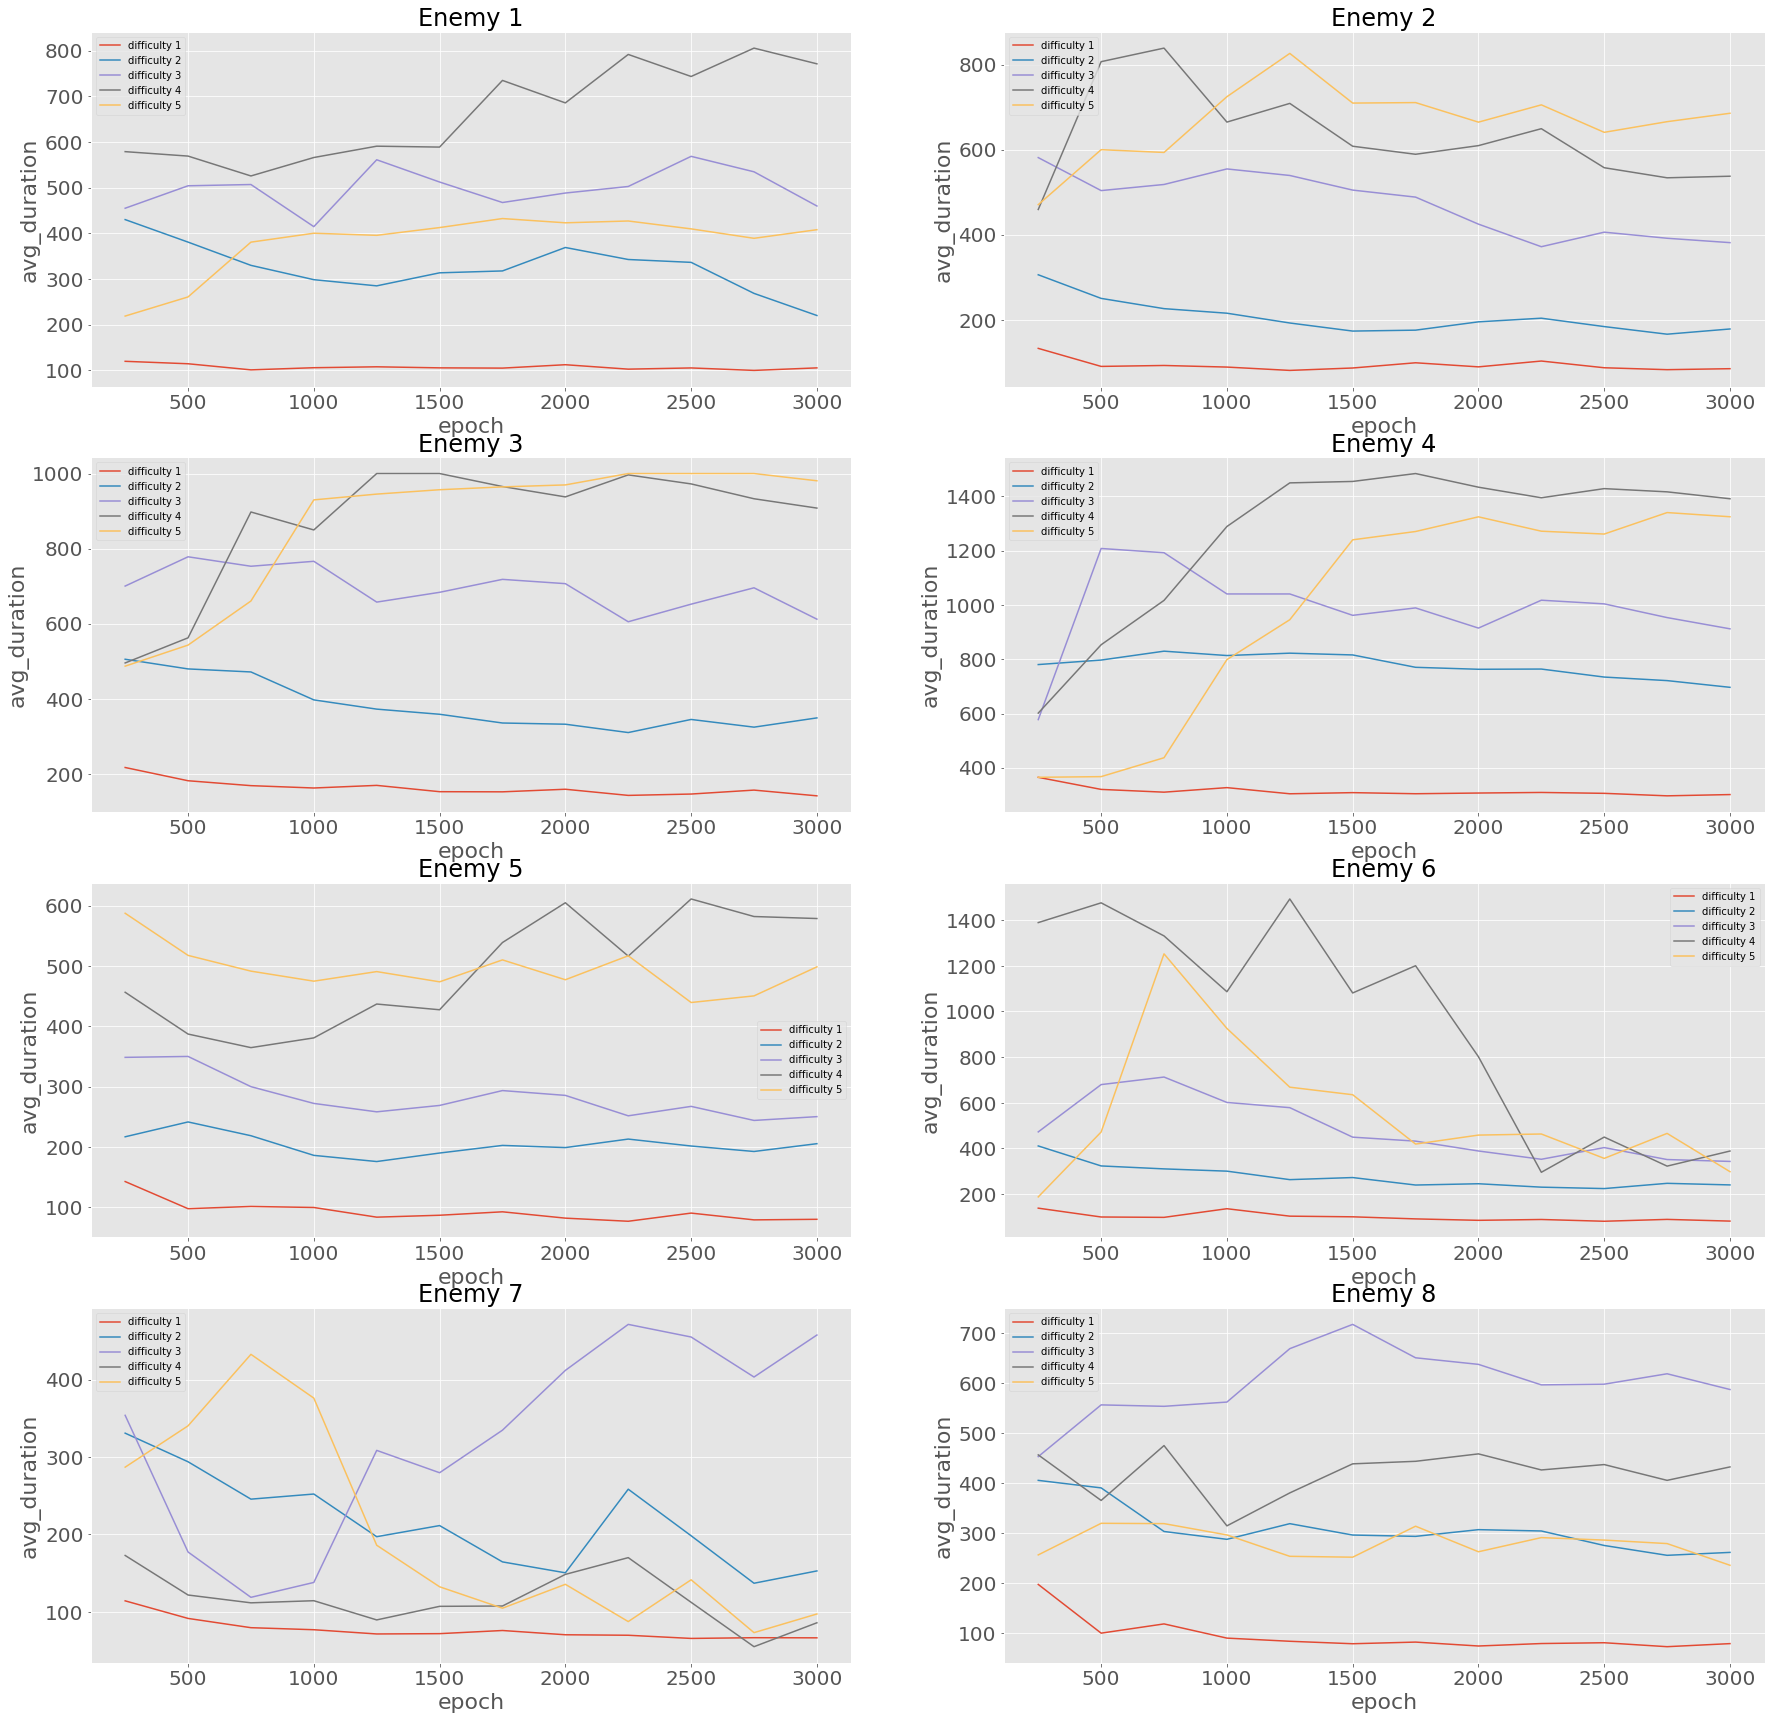

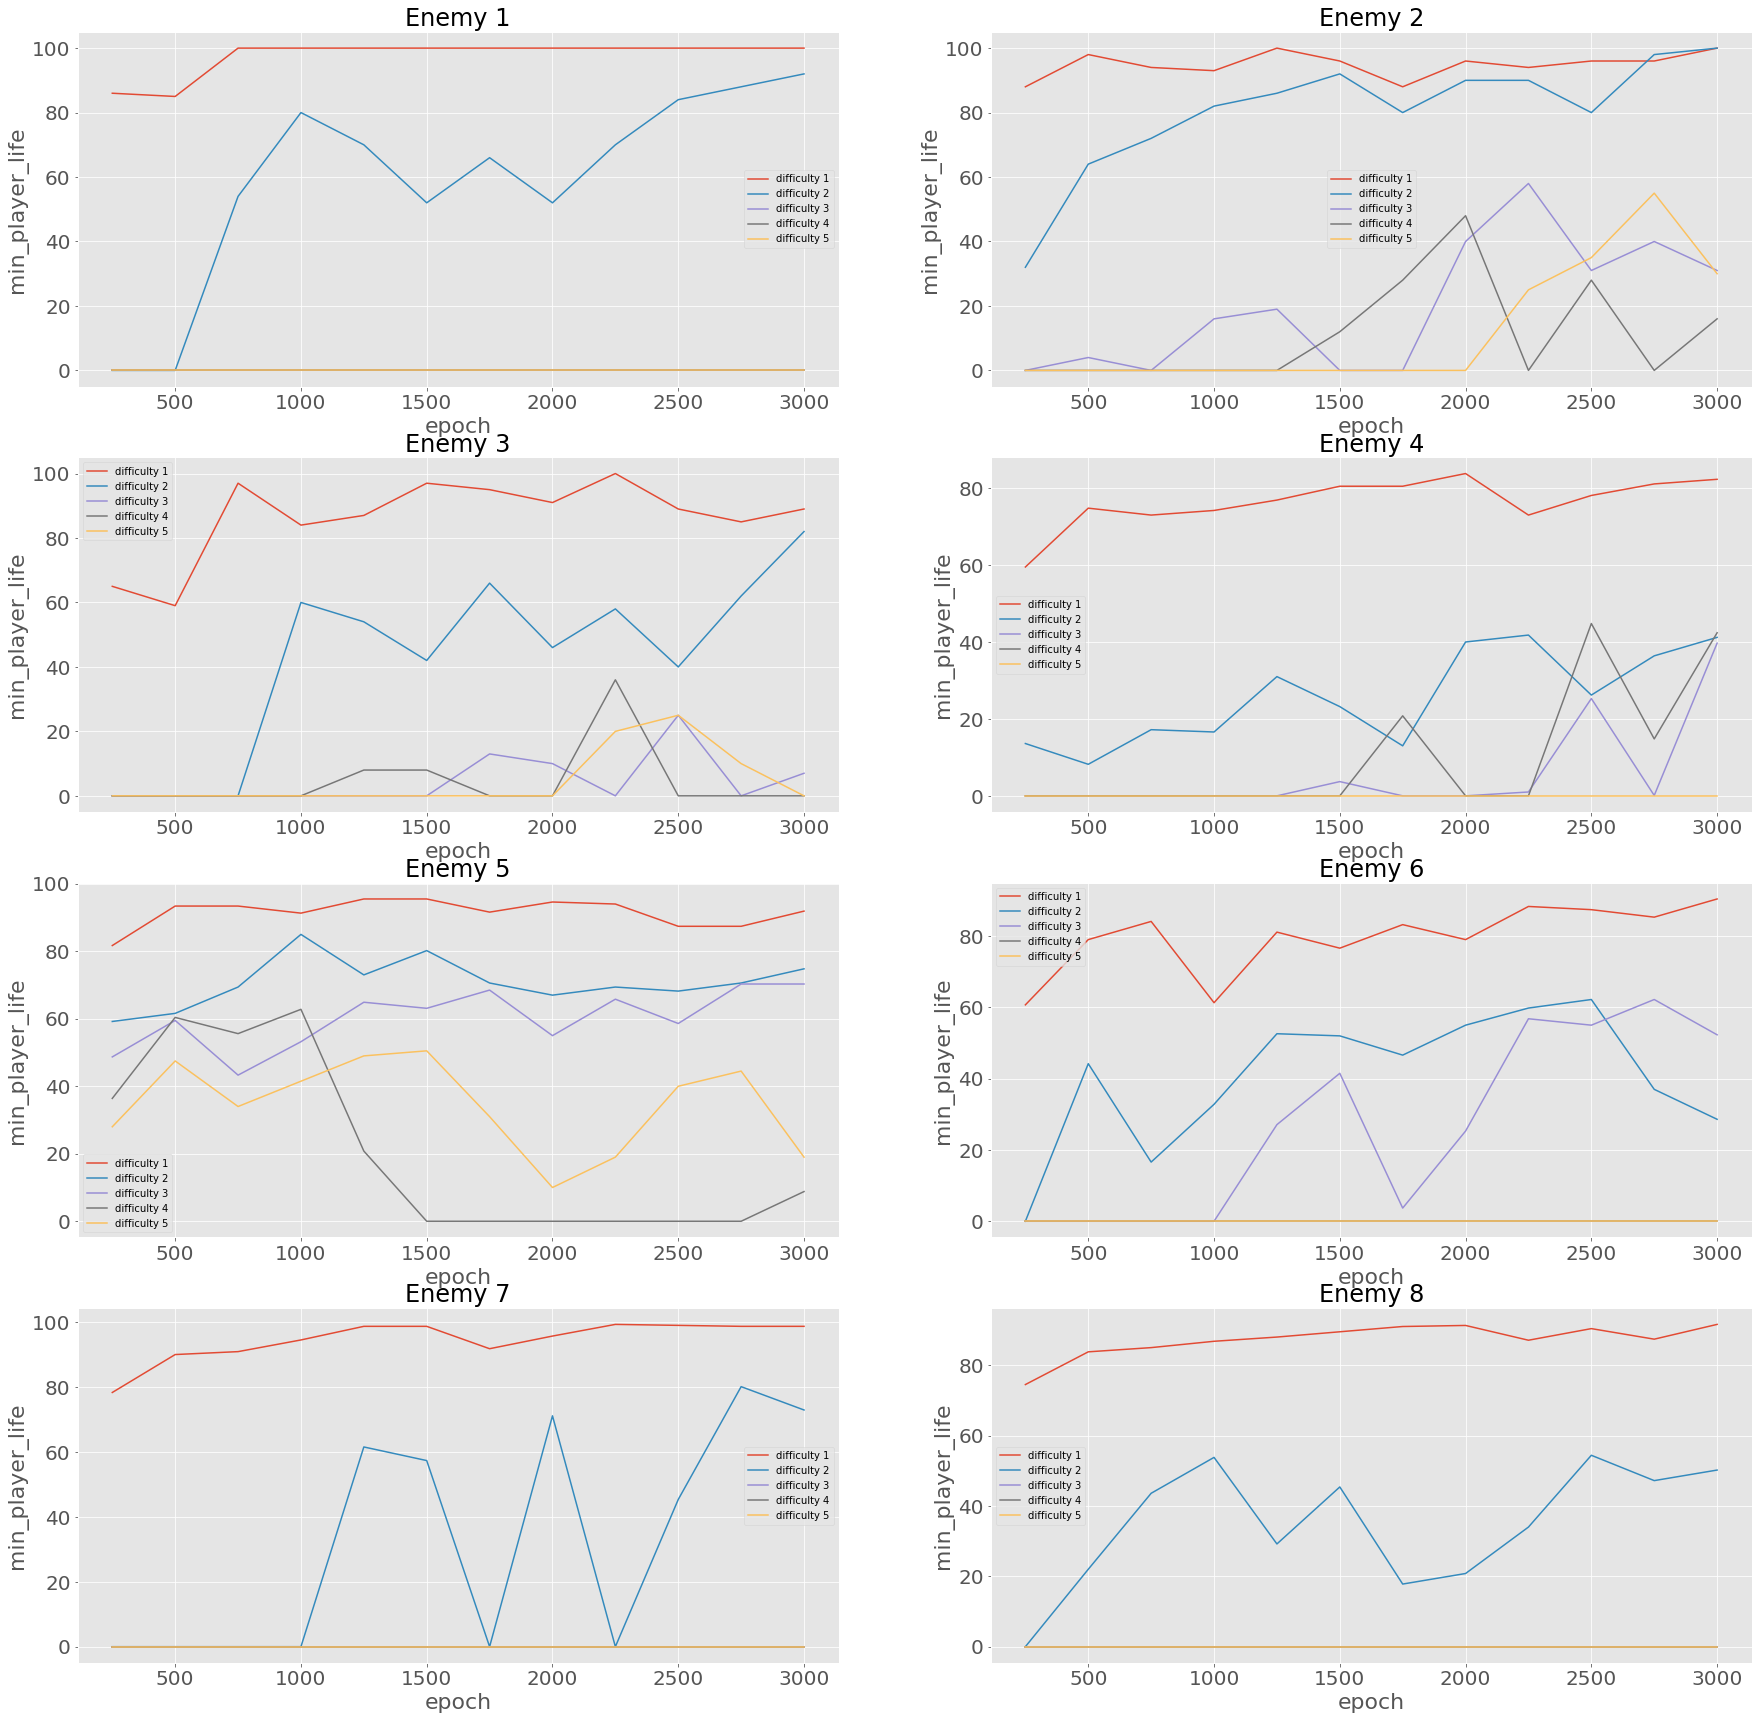

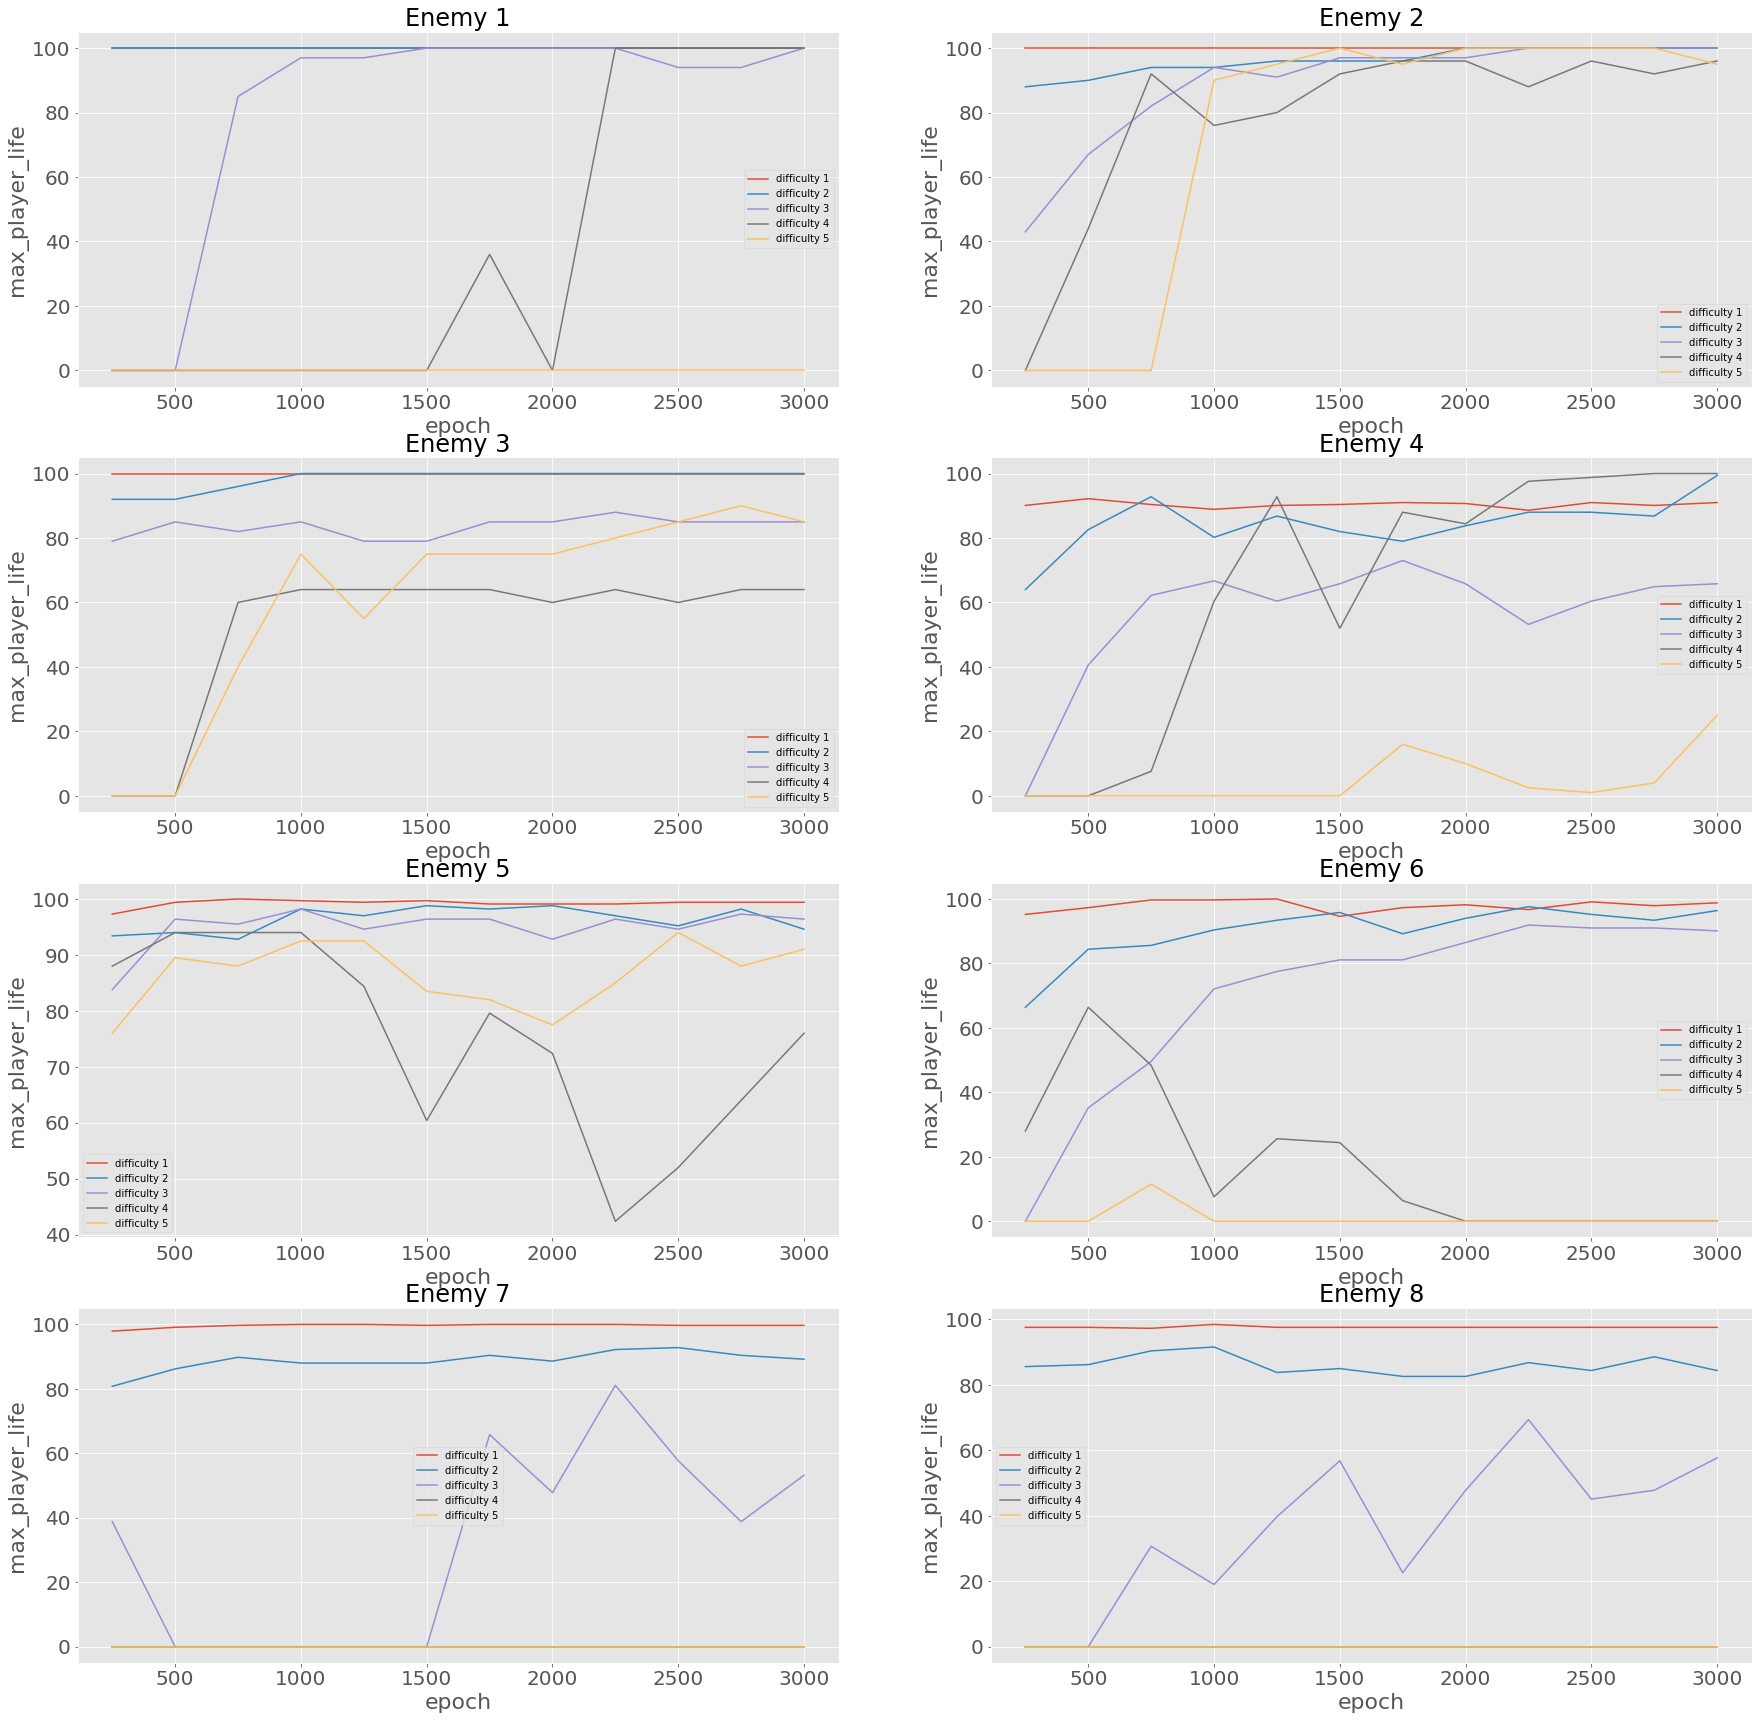

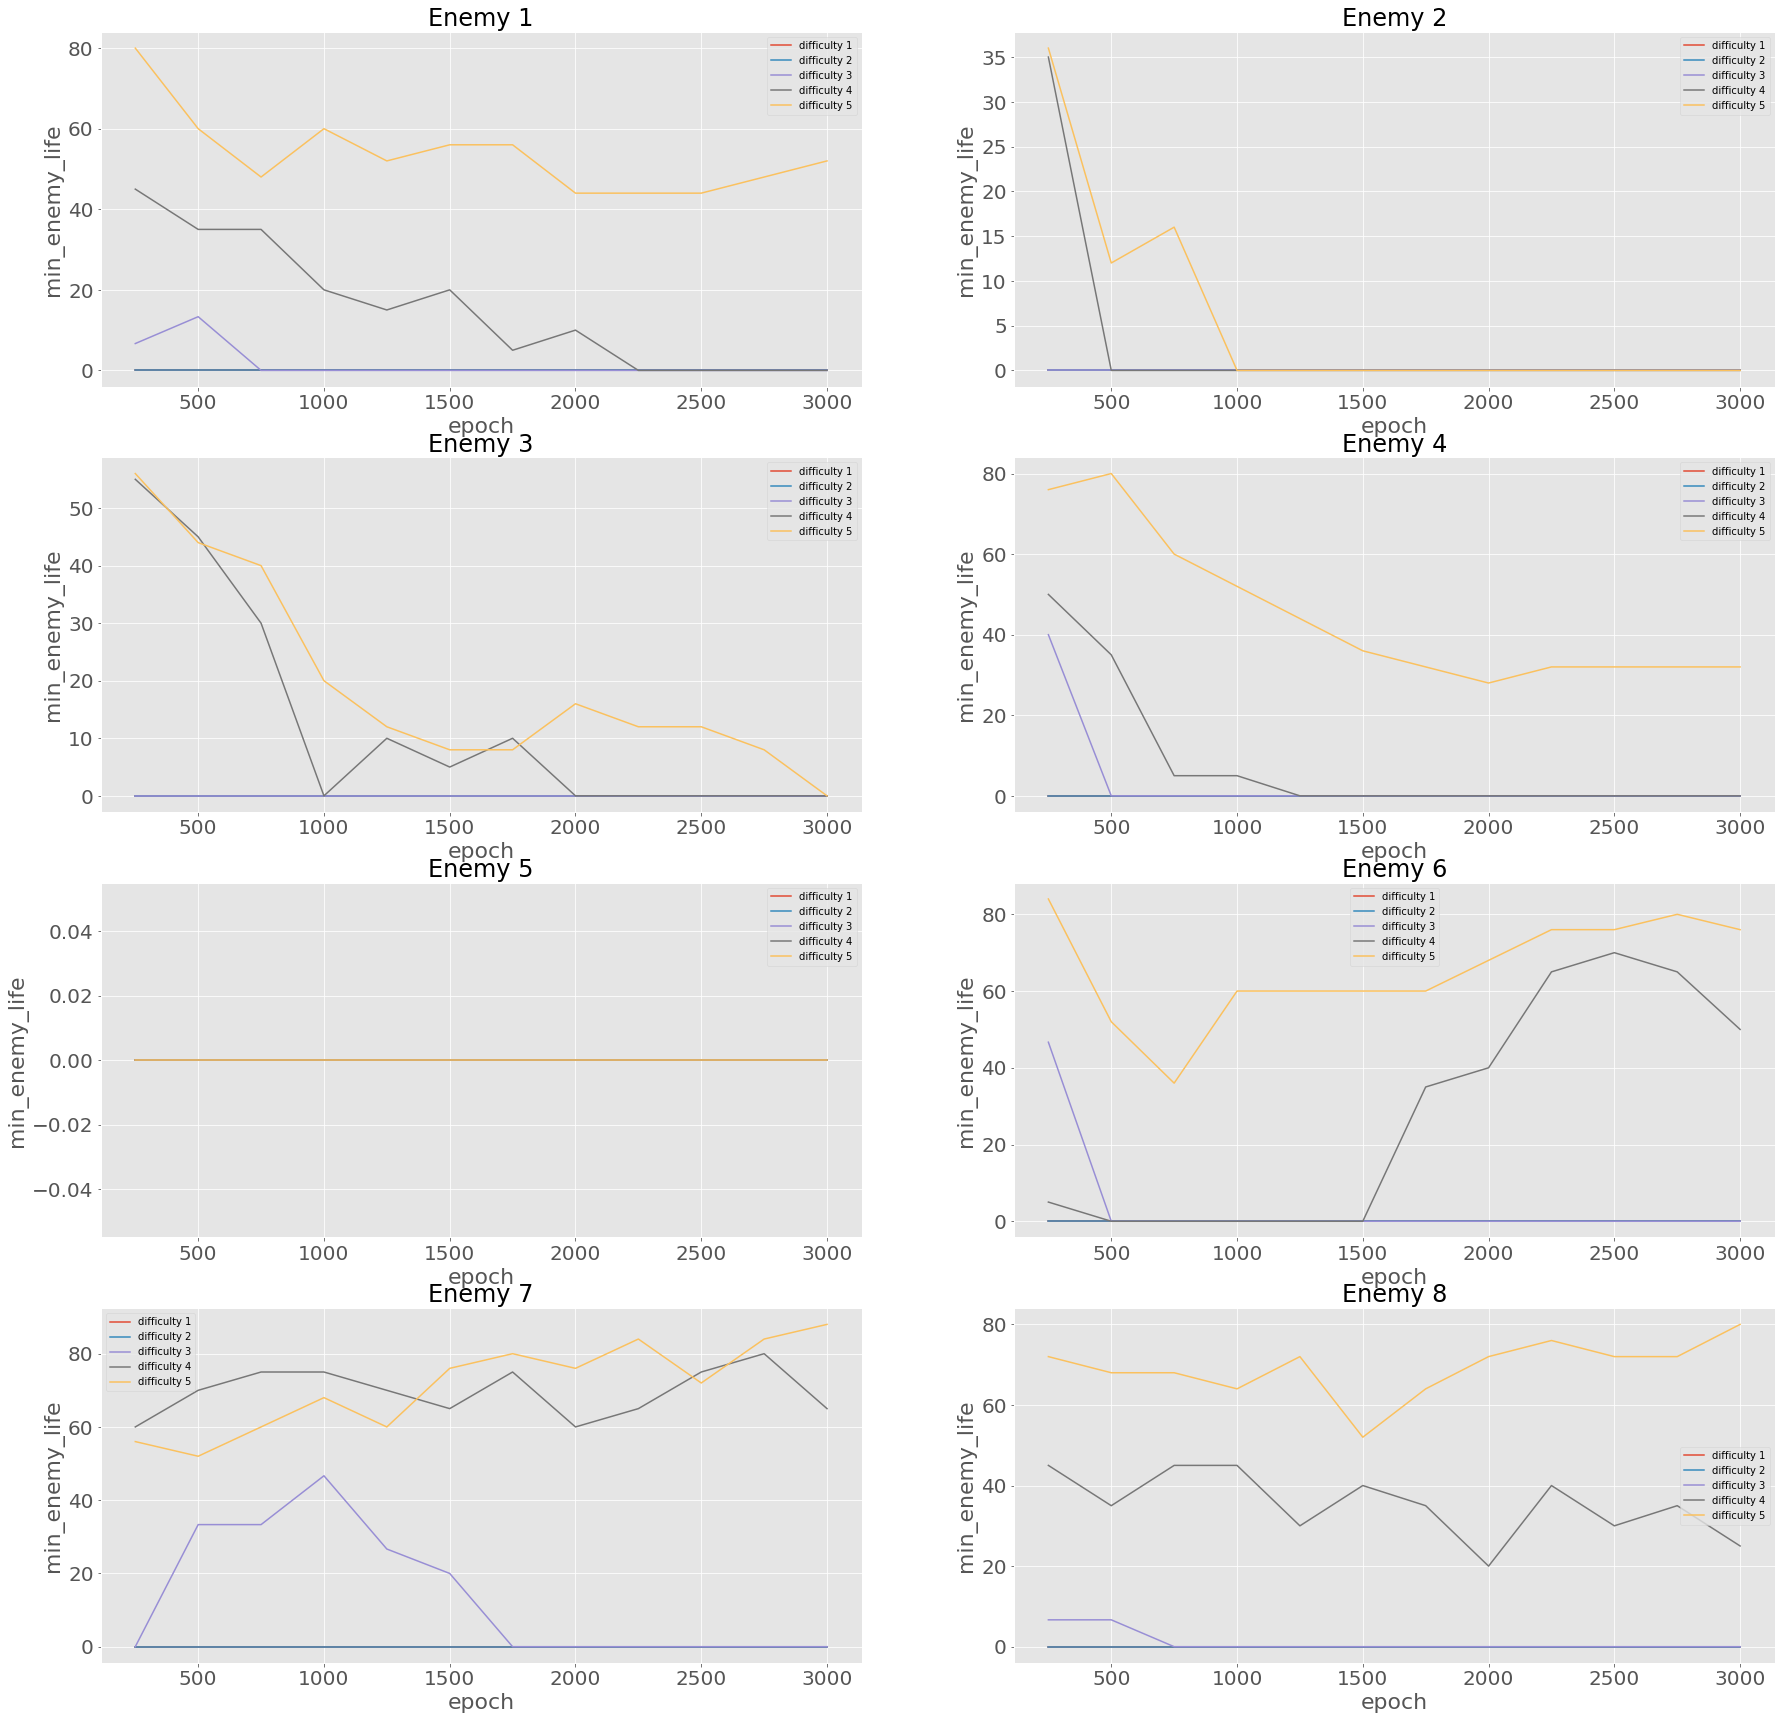

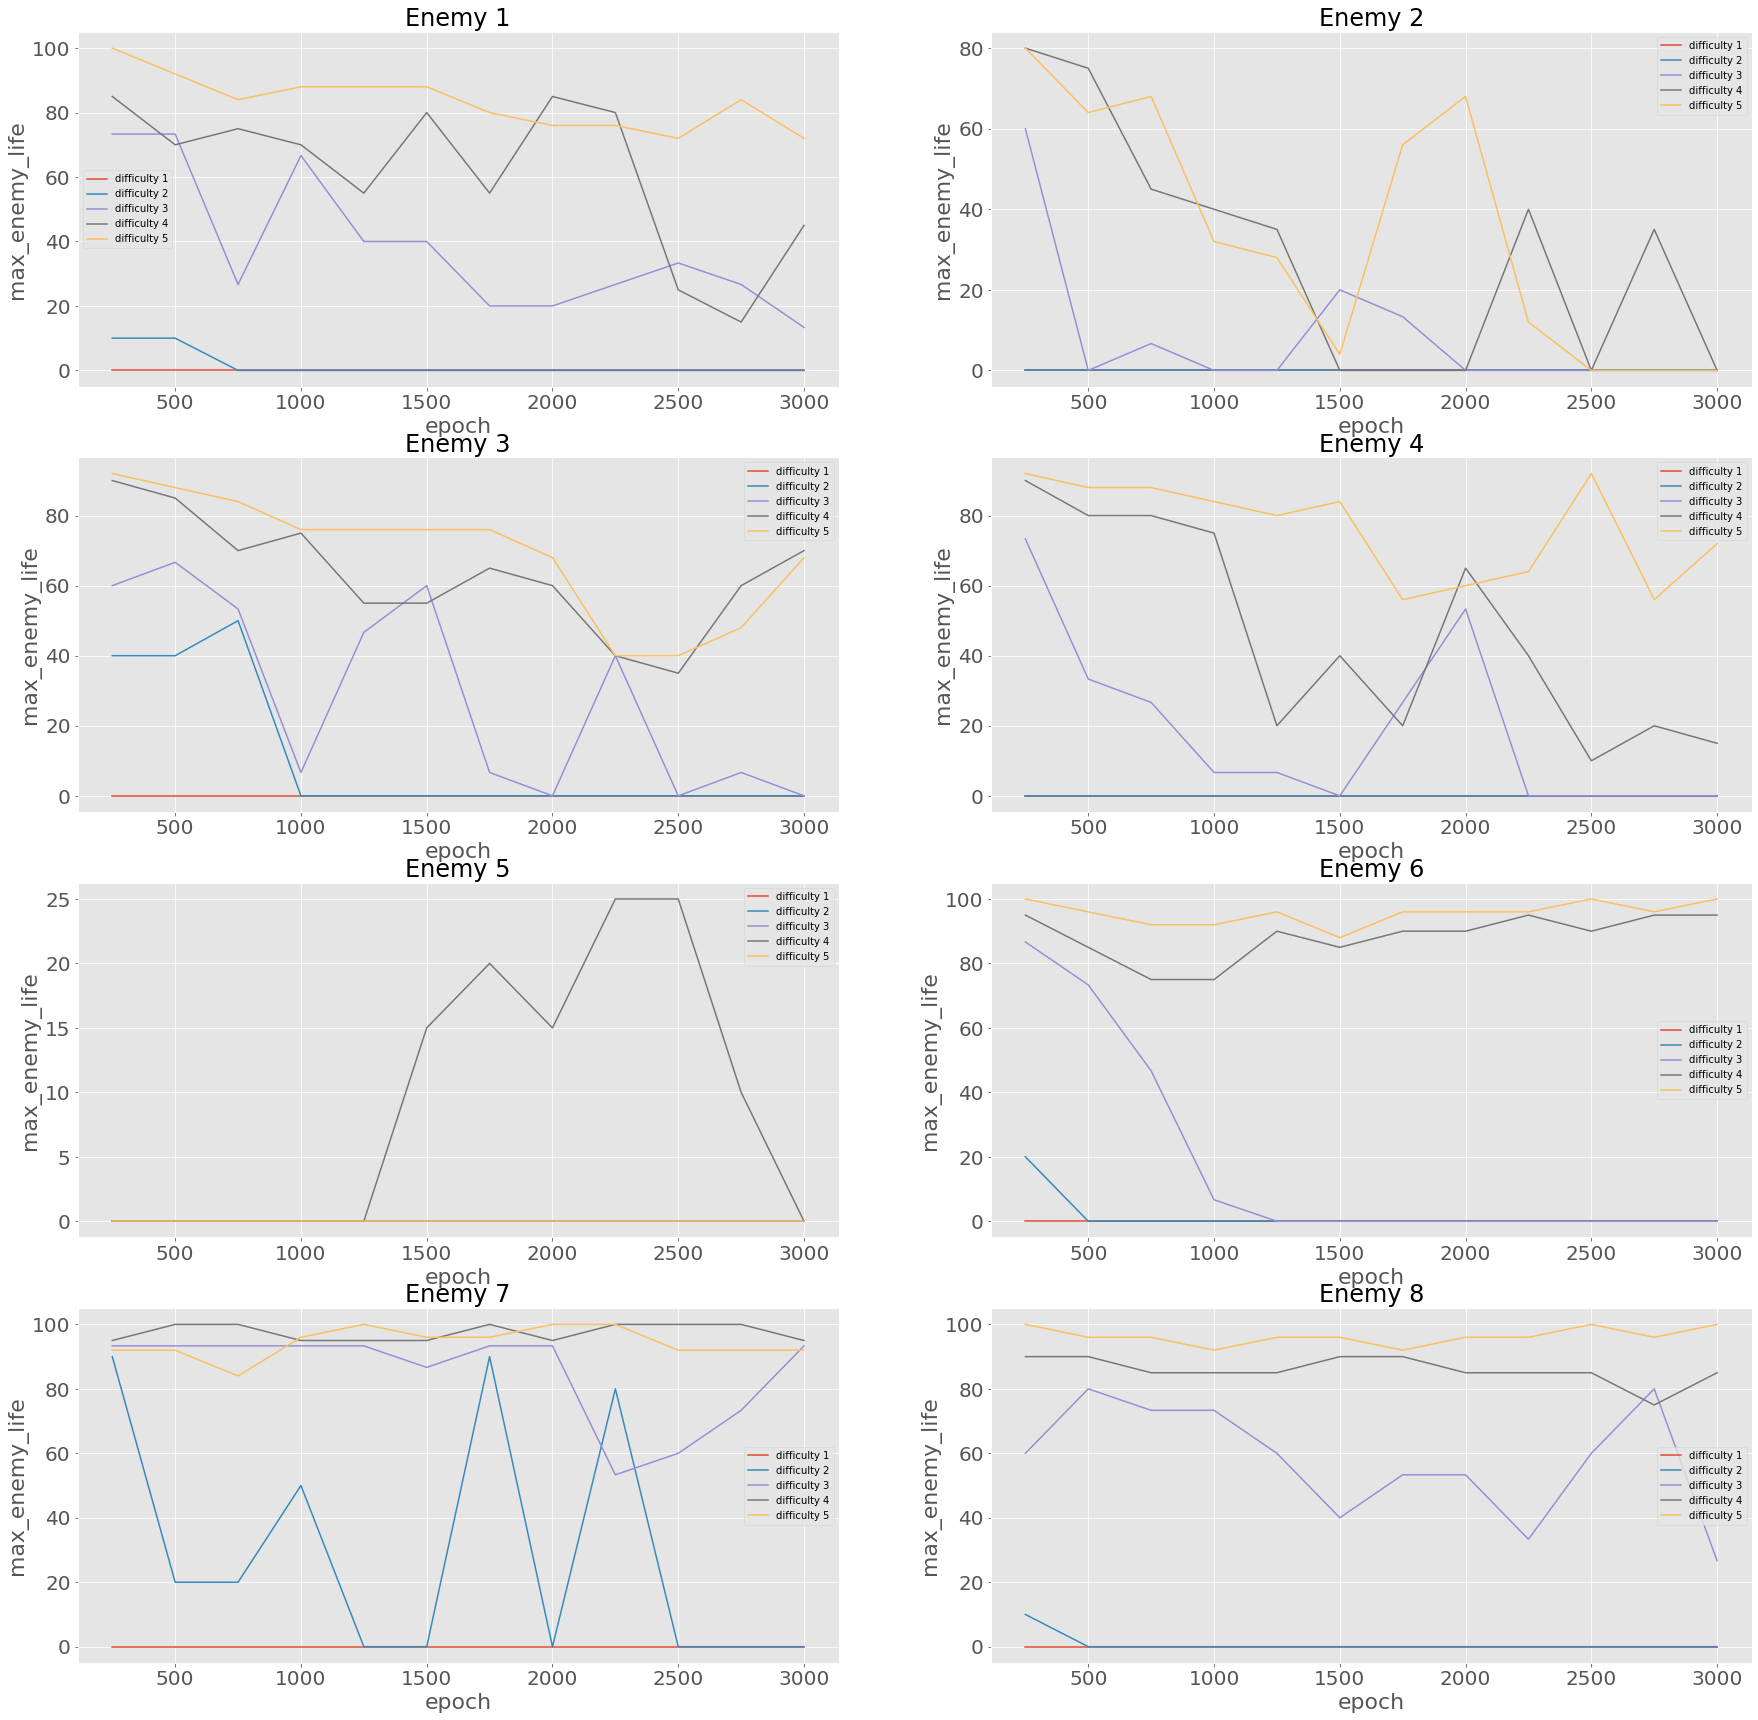

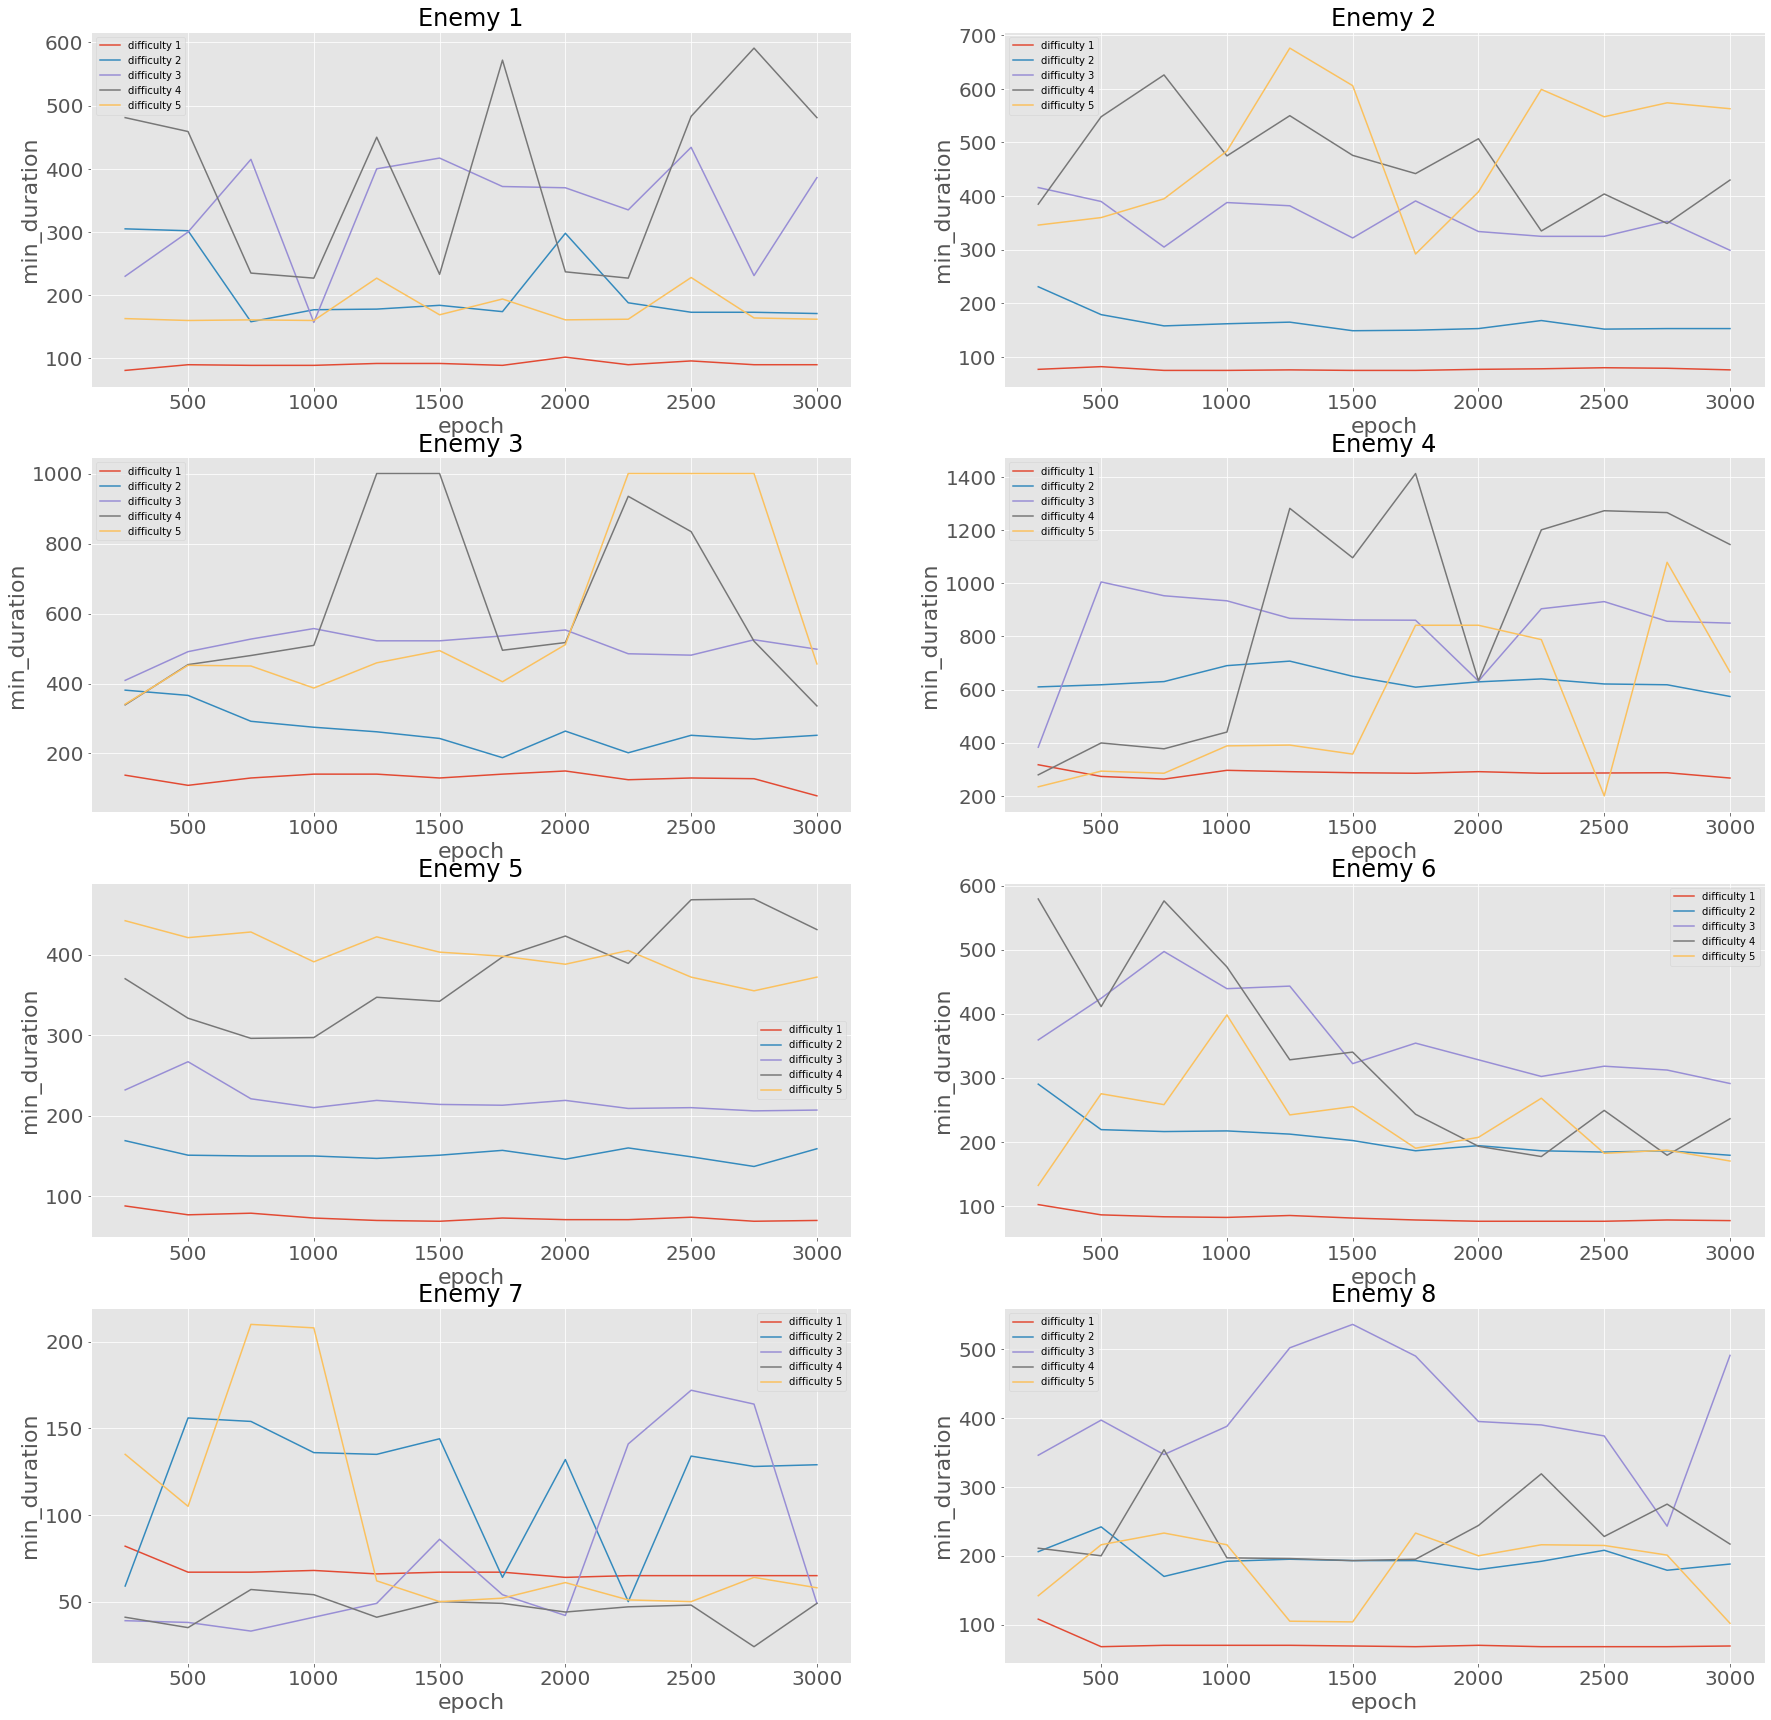

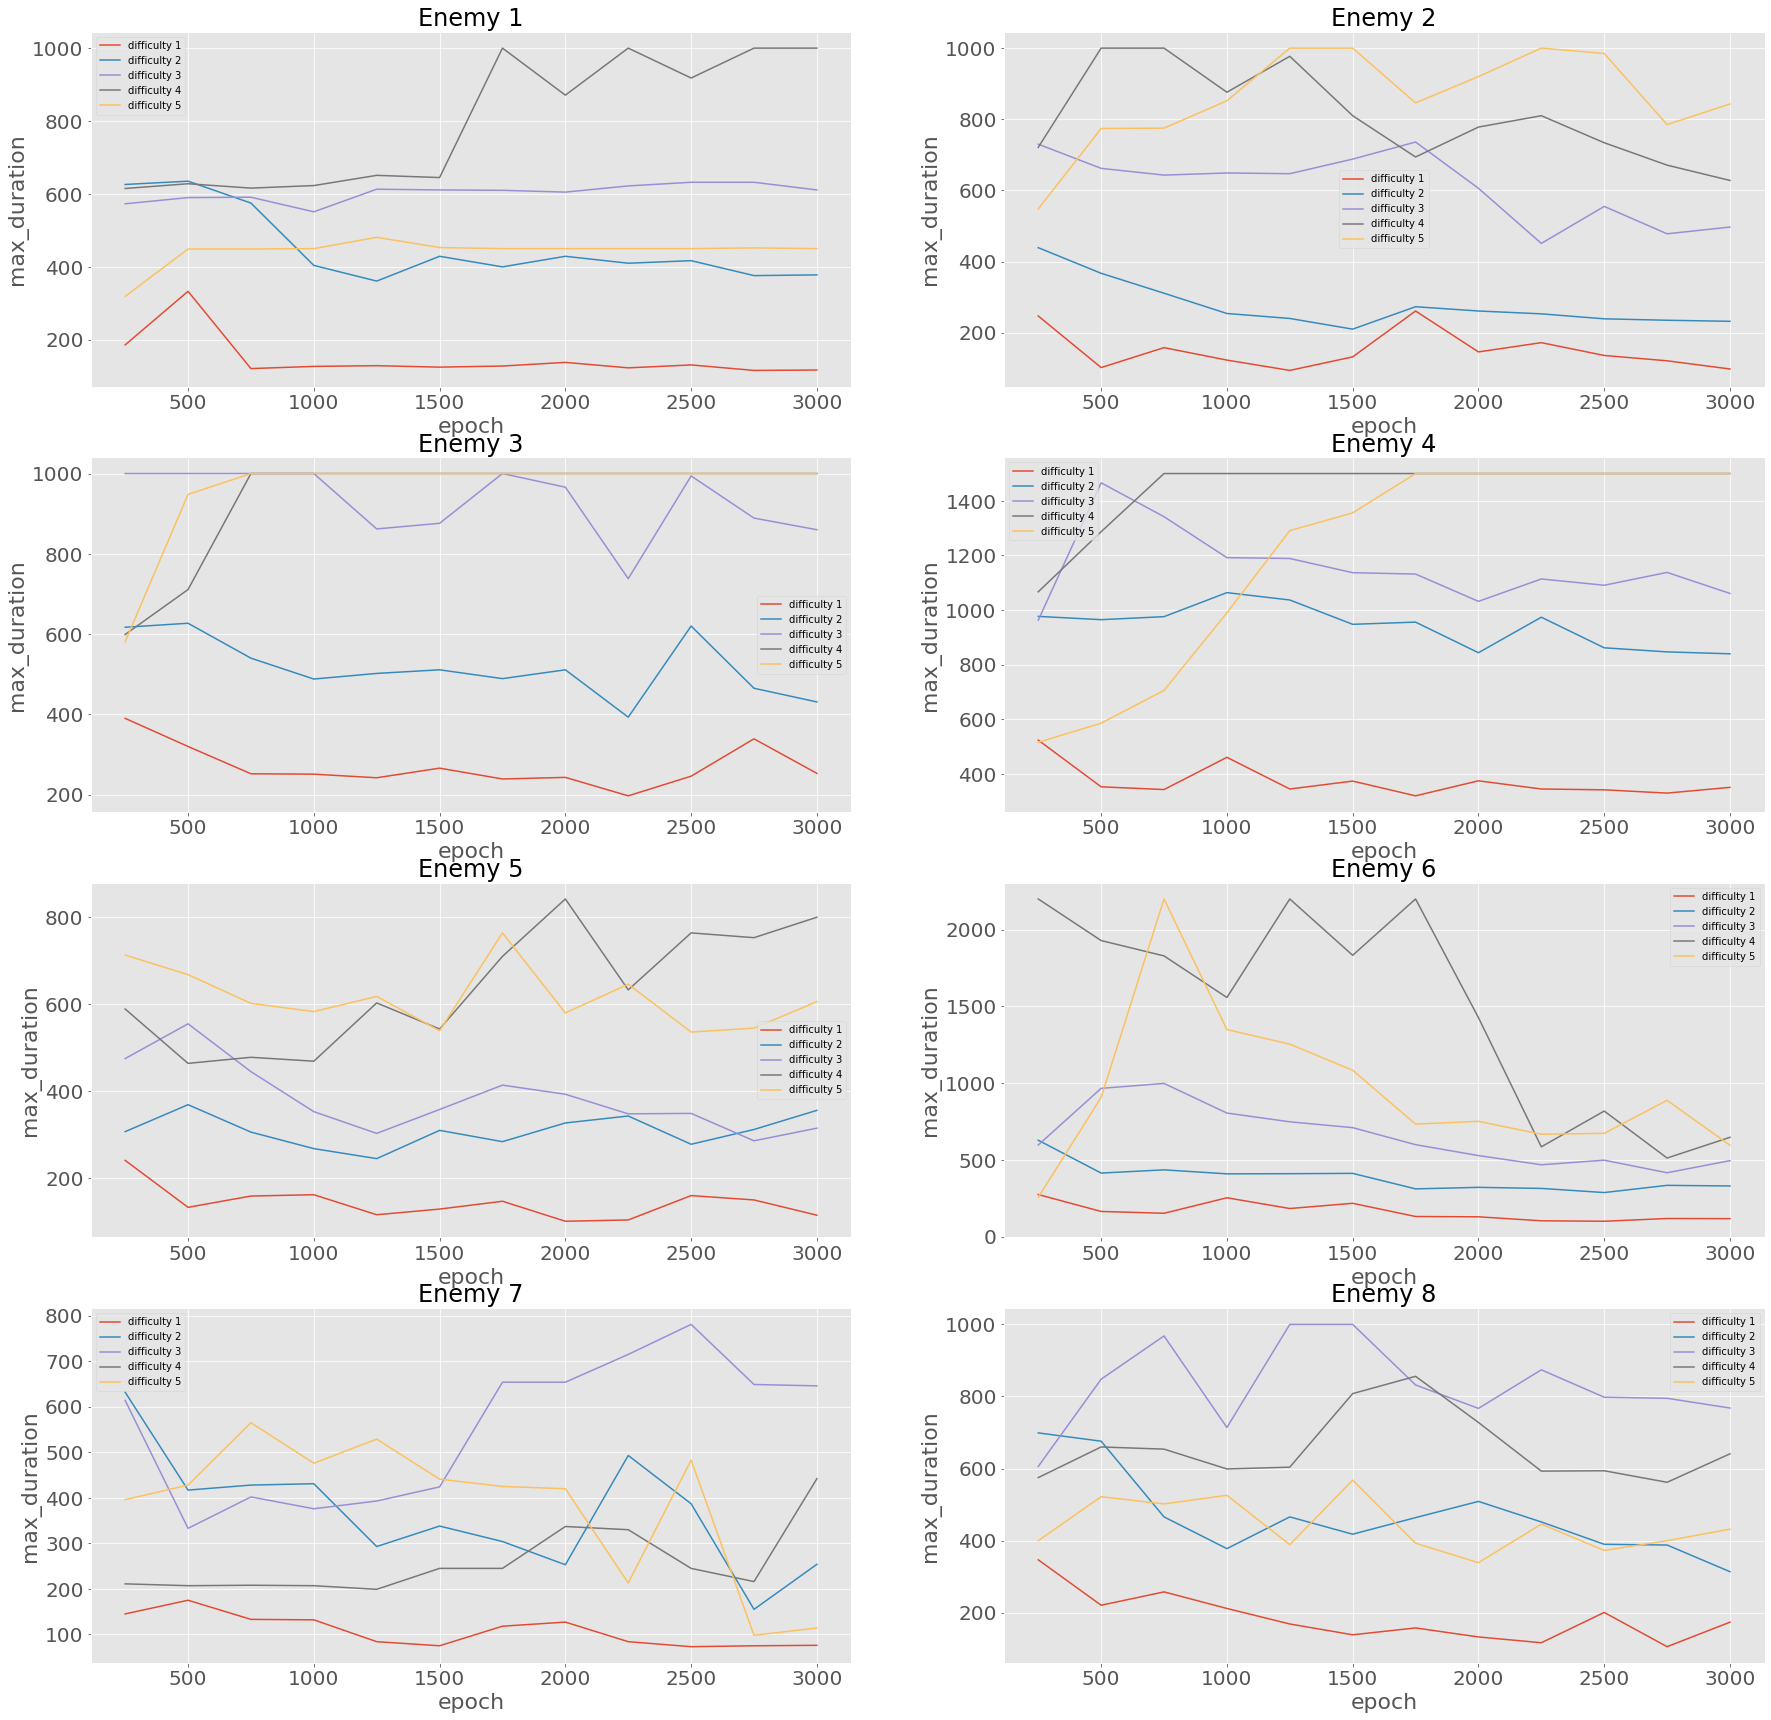

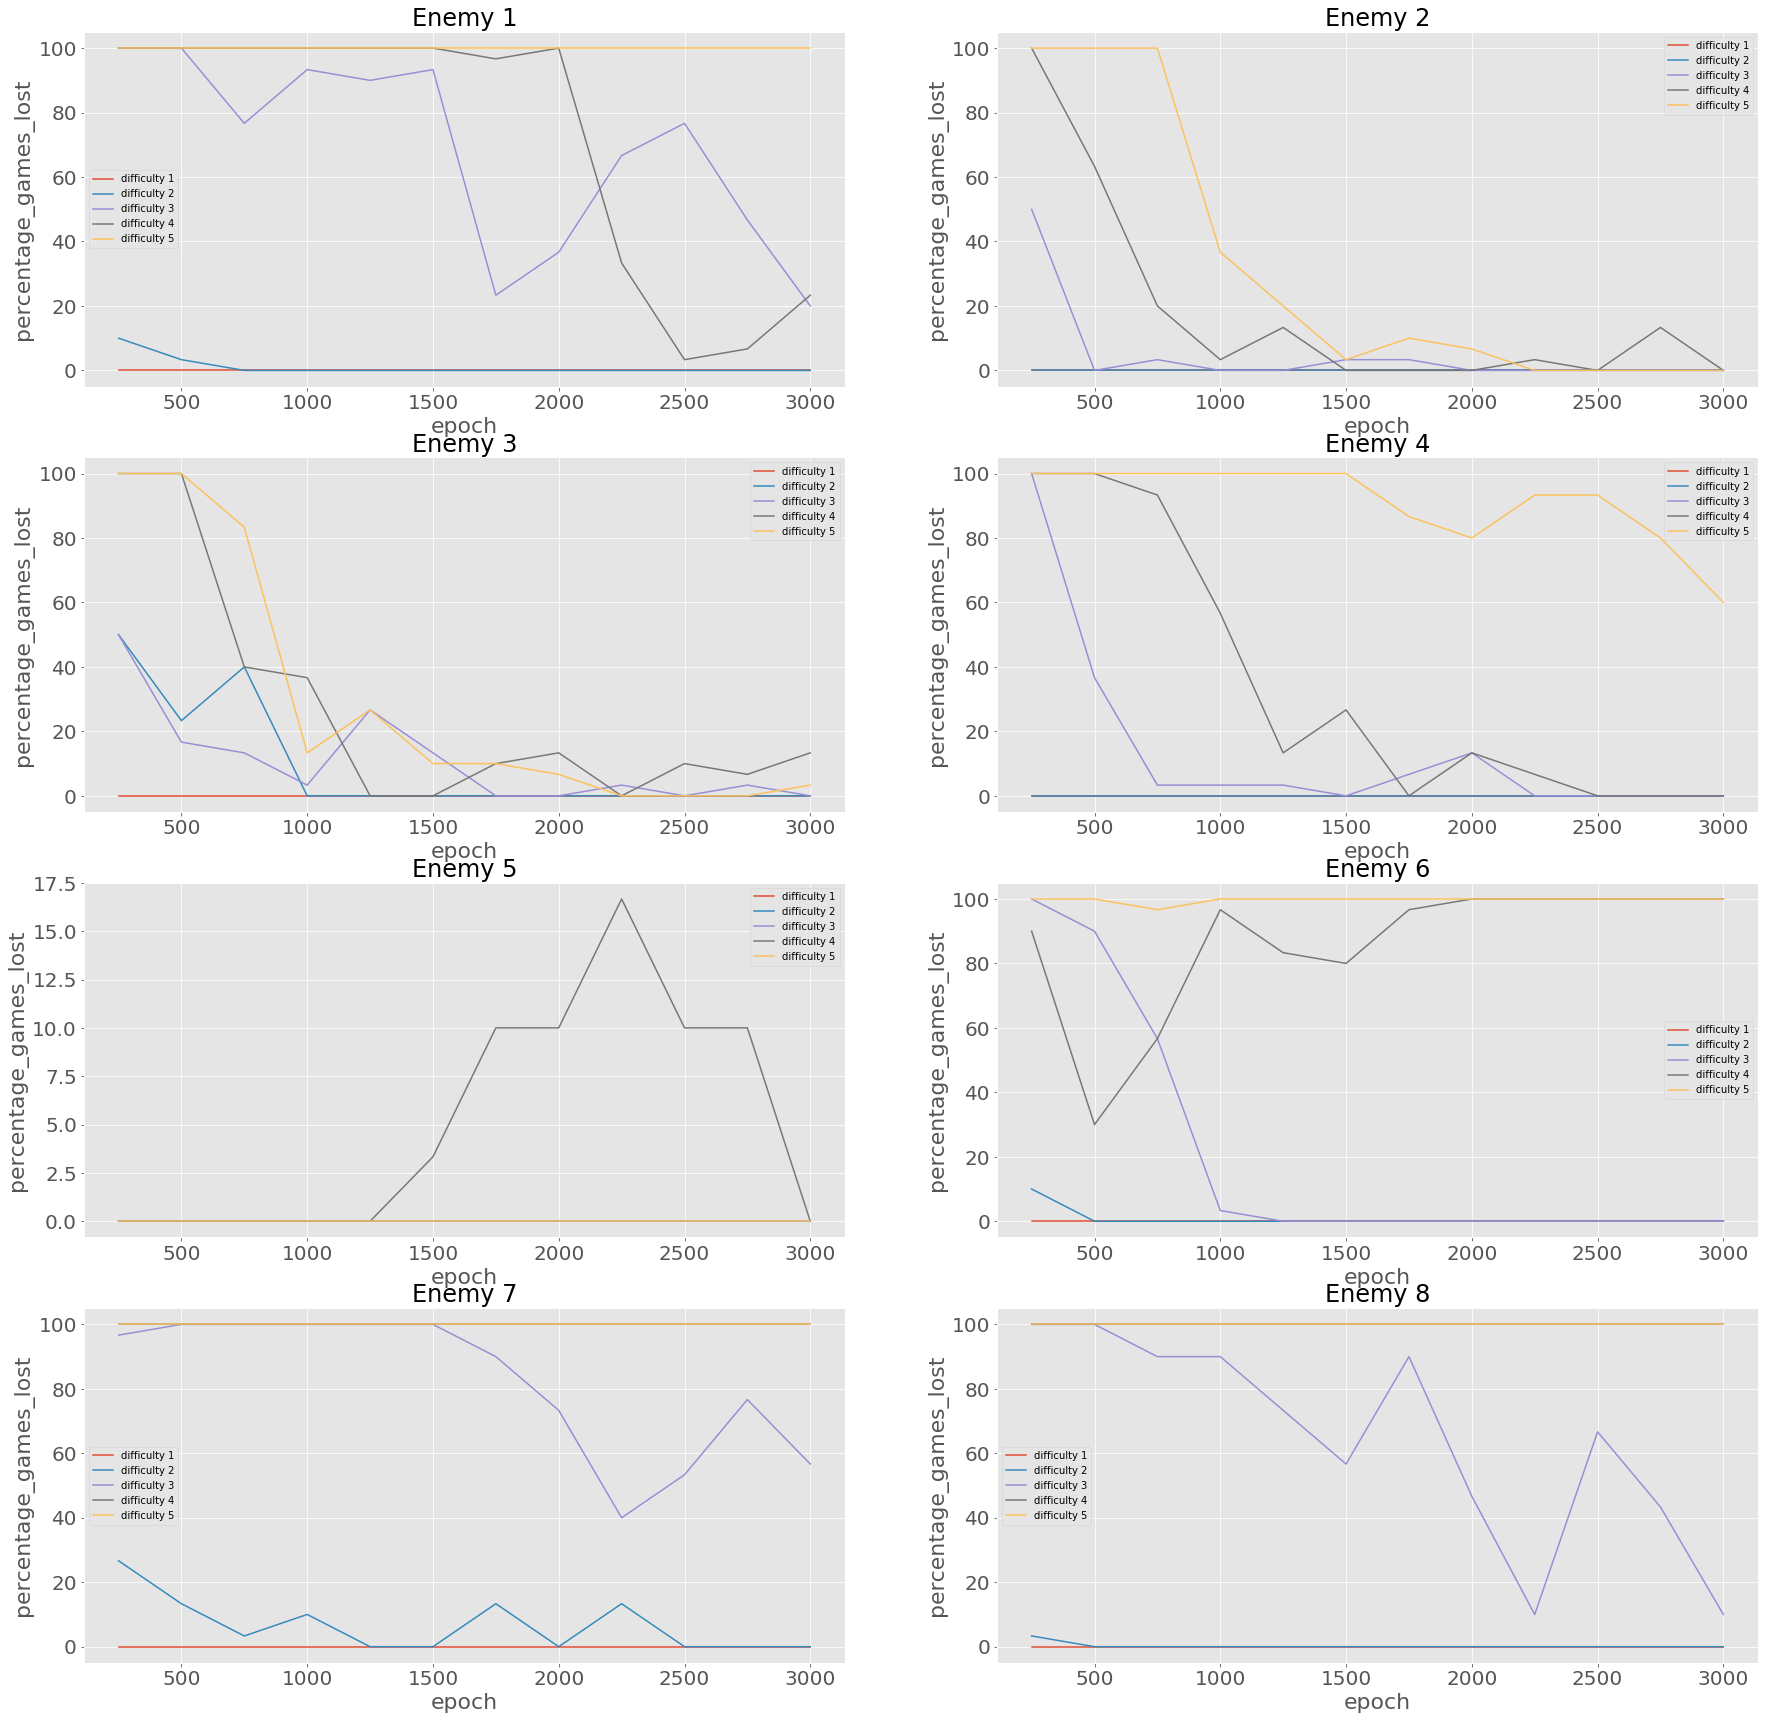

In [122]:
columns = difficulty_to_list_of_results[1][250].columns[1:]

for column in columns:
    df_gain = compute_final_df_for_column(column)

    fig, ax = plt.subplots(4, 2, figsize=(30, 30))

    for enemy in range(1, 9):
        _ax = ax[(enemy - 1) // 2, (enemy - 1) % 2]    
        for difficulty in range(1, 6):
            _ = df_gain.query(f'difficulty=={difficulty} and enemy=={enemy}') \
                    .set_index('epoch')[column].plot(ax=_ax, label=f'difficulty {difficulty}')
        _ = _ax.set_title(f'Enemy {enemy}')
        _ = _ax.set_ylabel(column)
        _ = _ax.legend()
        
    fig.savefig(f'paper/images/general_{column}_per_epoch_per_enemy.eps', format='eps')    